# <b> <font color='#A20025'> 📚 Chapter 7: Unsupervised Learning: Repurposing Drugs, Curating Compounds, & Screening Fragments

*This notebook contains the code examples in chapter 7. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH07_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers
- Key methods in unsupervised learning
- Application of dimensionality reduction for drug repurposing
- Clustering to facilitate the design of diverse and focused compound libraries
- How to leverage density estimation for pharmacophore modeling
- The fragment-based drug design paradigm

## <b> <font color='#A20025'> ⚙️ Environment Setup 

**❗️LOCAL ENVIRONMENT:** If you are running the Python notebook locally on your computer, then we recommend following the README setup instructions on how to use conda (or a similar package) to set up an environment using the file `ml4dd2025.yml`

**❗️COLAB ENVIRONMENT:** If you are running the code via an instance on Google Colab, you can download the necessary files and create the environment by running the following cells marked as **Colab users only**.

In [ ]:
# Colab users only
import os
CHAPTER = "ch07"
os.makedirs(f"artifacts/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}/raw", exist_ok=True)
os.makedirs(f"data/{CHAPTER}/processed", exist_ok=True)
os.makedirs(f"figures/{CHAPTER}", exist_ok=True)
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch07/raw/CH07_activity_data.csv" -O "data/ch07/raw/CH07_activity_data.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch07/raw/CH07_drug_repurposing_hub.csv" -O "data/ch07/raw/CH07_drug_repurposing_hub.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch07/raw/mpro_frags.sdf" -O "data/ch07/raw/mpro_frags.sdf"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/ml4dd2025.yml" -O "env.yml"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/utils.py" -O "utils.py"

In [ ]:
# Colab users only
!pip install -q condacolab
import condacolab
condacolab.install() #  The kernel will restart after this cell has run, which is normal.

In [ ]:
# Colab users only
# Verify condalab installation
import condacolab
condacolab.check()

In [ ]:
# Colab users only
# We can only use the base environment in `condacolab`, so we will update it with the `env.yml` file we downloaded earlier.
!mamba env update -n base -f env.yml

### <b> <font color='#A20025'> Import Packages 

Now let's import all the packages we'll need for this chapter.

In [63]:
import os

# Core data science and visualization packages
import itertools
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors
import pandas as pd
import seaborn as sns
import umap
from tqdm import tqdm

# Dimensionality reduction and clustering
from minisom import MiniSom
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import locally_linear_embedding
from sklearn.metrics import (
    calinski_harabasz_score, 
    silhouette_score, 
    davies_bouldin_score
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import (
    AllChem, 
    DataStructs, 
    Draw, 
    PandasTools,
    BRICS,
    rdFingerprintGenerator, 
    rdMolDescriptors
)
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.ML.Cluster import Butina
from rdkit.RDPaths import RDDataDir
from rdkit.Chem import ChemicalFeatures, MolToSmiles

# Statistical and density estimation packages
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs
from scipy import stats
from sklearn.neighbors import KernelDensity

### <b> <font color='#A20025'> Configure Settings

In [10]:
CHAPTER = "ch07"

In [4]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [34]:
# Matplotlib and Seaborn setup for consistent visualizations
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    colors = ["#A20025", "#6C8EBF", "#21130d"]  # Define a color palette
    sns.set_palette(sns.color_palette(colors))
    plt.rcParams['figure.dpi'] = 100 # Adjust for better resolution inline
    plt.rcParams['savefig.dpi'] = 600 # High resolution for saved figures
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 12   
    plt.rcParams['xtick.labelsize'] = 12   
    plt.rcParams['ytick.labelsize'] = 12    

setup_visualization_style()
%matplotlib inline

COLORS = ["#A20025", "#6C8EBF", "#21130d"]

In [6]:
def save_figure(fig, filename, formats=('png', 'pdf'), dpi=600):
    """
    Save a matplotlib figure in multiple formats with consistent settings.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure to save
    filename : str
        Base filename without extension
    formats : tuple
        File formats to save (default: png and pdf)
    dpi : int
        Resolution for raster formats
    """
    for fmt in formats:
        full_path = f'figures/{CHAPTER}/{filename}.{fmt}'
        fig.savefig(full_path, bbox_inches='tight', dpi=dpi)
        print(f"Figure saved as {full_path}")

In [7]:
# RDKit drawing setup
def setup_rdkit_drawing():
    """Configure RDKit drawing settings for consistent molecular visualizations"""
    d2d = Draw.MolDraw2DSVG(-1, -1)
    dopts = d2d.drawOptions()
    dopts.useBWAtomPalette()
    dopts.setHighlightColour((.635, .0, .145, .4))
    dopts.baseFontSize = 1.0
    dopts.additionalAtomLabelPadding = 0.15
    dopts.dotsPerAngstrom = 100
    return dopts

rdkit_drawing_options = setup_rdkit_drawing()

## <b> <font color='#A20025'> 1️⃣ Dimensionality Reduction: Drug Repurposing

This section demonstrates how dimensionality reduction techniques can be applied to drug repurposing. 
We'll explore Self-Organizing Maps (SOMs) and Universal Manifold Approximation and Projection (UMAP)
to identify potential drug repurposing candidates.

### <b> <font color='#A20025'> Data Preparation

First, we'll load the COVID Moonshot dataset and compute Morgan fingerprints (2048 bits, radius 2).
We'll also define activity labels based on literature precedence to facilitate additional analysis.
Although unsupervised learning doesn't require labels, they help us evaluate the results.

In [8]:
def load_and_process_activity_data(file_path, save_processed=True):
    """
    Load and process activity data, computing Morgan fingerprints.
    
    Parameters:
    -----------
    file_path : str
        Path to the raw activity data CSV
    save_processed : bool
        Whether to save the processed data
        
    Returns:
    --------
    pandas.DataFrame, numpy.ndarray
        Processed dataframe and fingerprints array
    """
    try:
        # Load the data
        print(f"Loading data from {file_path}...")
        data = pd.read_csv(file_path)
        
        # Generate Morgan fingerprints
        print("Computing Morgan fingerprints...")
        data['Morgan_Fingerprint'] = data['SMILES'].apply(
            lambda x: generate_morgan_fingerprint(x, radius=2, n_bits=2048)
        )
        
        # Remove entries with invalid fingerprints
        data = data.dropna(subset=['Morgan_Fingerprint'])
        print(f"Valid molecules after processing: {len(data)}")
        
        # Define activity labels based on IC50 values
        # 1: Active (f_avg_IC50 >= 5)
        # 2: Inactive (f_avg_IC50 < 5)
        # 3: Unknown
        data["label"] = np.where(
            data['f_avg_IC50'] >= 5, 1, 
            np.where(data['f_avg_IC50'] < 5, 2, 3)
        )
        
        # Convert the fingerprints to a numpy array
        fingerprints = np.array([list(fp) for fp in data['Morgan_Fingerprint']])
        
        if save_processed:
            # Save the fingerprints and processed data
            processed_dir = 'data/ch07/processed'
            os.makedirs(processed_dir, exist_ok=True)
            np.save(f'{processed_dir}/morgan_fingerprints.npy', fingerprints)
            data.to_csv(f'{processed_dir}/processed_CH07_activity_data.csv', index=False)
            print(f"Saved processed data to {processed_dir}")
        
        return data, fingerprints
    
    except Exception as e:
        print(f"Error loading or processing data: {str(e)}")
        raise

def generate_morgan_fingerprint(smiles, radius=2, fp_size=2048):
    """
    Convert a SMILES string to a Morgan fingerprint.
    
    Parameters:
    -----------
    smiles : str
        SMILES representation of a molecule
    radius : int
        Radius for Morgan fingerprint generation
    fp_size : int
        Size (number of bits) for the fingerprint
        
    Returns:
    --------
    numpy.ndarray
        Fingerprint as a numpy array
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Could not parse SMILES: {smiles}")
        
        # Generate Morgan fingerprint
        fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fp_size)
        fp = np.array(fp_gen.GetFingerprint(mol))
        
        return fp
    
    except Exception as e:
        print(f"Error generating fingerprint for {smiles}: {str(e)}")
        return np.nan

# Try to load pre-processed data first, if not available, process from raw data
try:
    print("Attempting to load pre-processed data...")
    data = pd.read_csv('data/ch07/processed/processed_CH07_activity_data.csv')
    fingerprints = np.load('data/ch07/processed/morgan_fingerprints.npy')
    print("Pre-processed data loaded successfully.")
except (FileNotFoundError, IOError):
    print("Pre-processed data not found. Processing from raw data...")
    data, fingerprints = load_and_process_activity_data('data/ch07/raw/CH07_activity_data.csv')

# Define label names for reference
label_names = {1: 'Active', 2: 'Inactive', 3: 'Unknown'}
print(f"Data distribution by label: {data['label'].map(label_names).value_counts()}")

Attempting to load pre-processed data...
Pre-processed data loaded successfully.
Data distribution by label: label
Active      1144
Inactive     782
Unknown      136
Name: count, dtype: int64


### <b> <font color='#A20025'> High Throughput Screening Data

In drug discovery, high-throughput screening (HTS) is used to test thousands of compounds for biological activity. 
The results are typically analyzed using dose-response curves, which show how a compound's effect varies with concentration.
Below, we demonstrate how to fit a Hill equation to dose-response data.

Figure saved as figures/ch07/fitted_dose_response_curve.png
Figure saved as figures/ch07/fitted_dose_response_curve.pdf
Fitted parameters:
E_max: 93.38
IC50: 0.08
Hill coefficient (n): 0.67


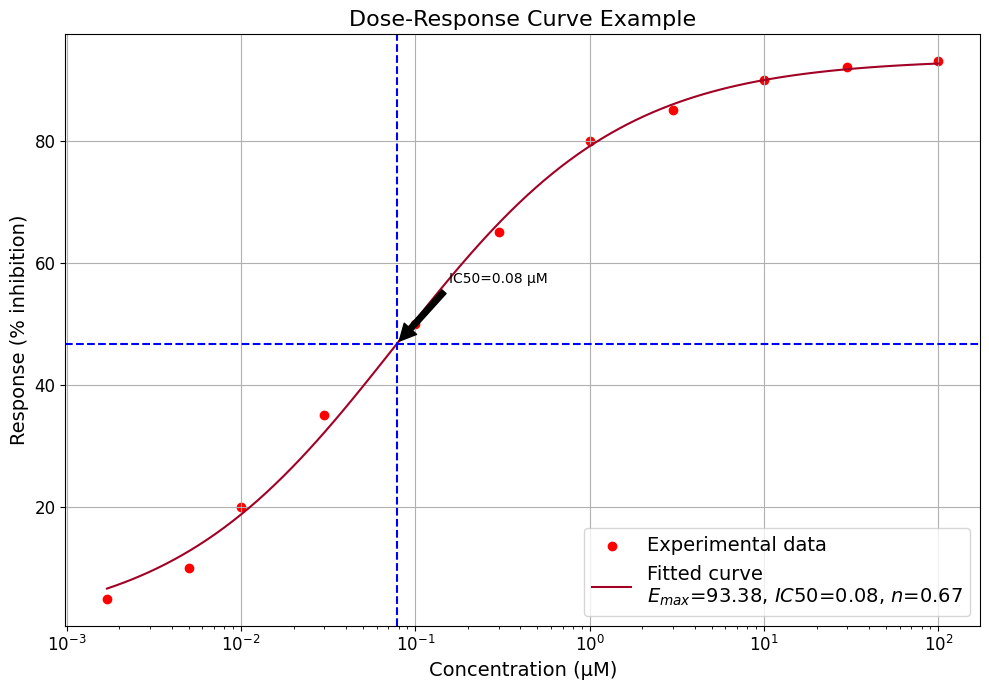

In [11]:
def hill_equation(conc, E_max, IC50, n):
    """
    Hill equation for modeling dose-response relationships.
    
    Parameters:
    -----------
    conc : float or array
        Concentration(s) of the compound
    E_max : float
        Maximum effect
    IC50 : float
        Concentration giving half-maximal effect
    n : float
        Hill coefficient (steepness of the curve)
        
    Returns:
    --------
    float or array
        Response at the given concentration(s)
    """
    return E_max * conc**n / (IC50**n + conc**n)

def fit_and_plot_dose_response(concentrations, responses, title="Dose-Response Curve"):
    """
    Fit a Hill equation to dose-response data and plot the results.
    
    Parameters:
    -----------
    concentrations : array-like
        Concentrations of the compound
    responses : array-like
        Measured responses at each concentration
    title : str
        Title for the plot
        
    Returns:
    --------
    tuple
        (E_max, IC50, n) - the fitted parameters
    """
    # Initial guesses for E_max, IC50, and Hill coefficient (n)
    initial_guesses = [100, 1, 1]
    
    # Constraints: E_max between 0 and 100, IC50 between 0 and 100, n between 0.1 and 3
    param_bounds = ([0, 0, 0.1], [100, 100, 3])
    
    # Fit the Hill equation to the data using the Levenberg-Marquardt algorithm
    try:
        popt, pcov = curve_fit(
            hill_equation, 
            concentrations, 
            responses, 
            p0=initial_guesses, 
            bounds=param_bounds, 
            method='trf'
        )
        
        # Extract the optimal parameters
        E_max_opt, IC50_opt, n_opt = popt
        
        # Generate data for the fitted curve
        concentration_range = np.logspace(
            np.log10(concentrations.min()), 
            np.log10(concentrations.max()), 
            100
        )
        fitted_responses = hill_equation(concentration_range, *popt)
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.scatter(concentrations, responses, color='red', label='Experimental data')
        ax.plot(
            concentration_range, 
            fitted_responses, 
            label=f'Fitted curve\n$E_{{max}}$={E_max_opt:.2f}, $IC50$={IC50_opt:.2f}, $n$={n_opt:.2f}'
        )
        ax.set_xscale('log')
        ax.set_xlabel('Concentration (µM)')
        ax.set_ylabel('Response (% inhibition)')
        ax.set_title(title)
        ax.grid(True)
        
        # Annotate the IC50 value
        ic50_response = hill_equation(IC50_opt, E_max_opt, IC50_opt, n_opt)
        ax.axhline(y=ic50_response, color='blue', linestyle='--')
        ax.axvline(x=IC50_opt, color='blue', linestyle='--')
        ax.annotate(
            f'IC50={IC50_opt:.2f} µM', 
            xy=(IC50_opt, ic50_response), 
            xytext=(IC50_opt*2, ic50_response+10),
            arrowprops=dict(facecolor='black', shrink=0.05)
        )
        
        ax.legend()
        fig.tight_layout()
        
        # Save the figure
        save_figure(fig, 'fitted_dose_response_curve')
        
        print(f"Fitted parameters:\nE_max: {E_max_opt:.2f}\nIC50: {IC50_opt:.2f}\nHill coefficient (n): {n_opt:.2f}")
        return E_max_opt, IC50_opt, n_opt
    
    except Exception as e:
        print(f"Error fitting dose-response curve: {str(e)}")
        return None

# Example dose-response data
concentrations = np.array([0.0017, 0.005, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100])  # in µM
responses = np.array([5, 10, 20, 35, 50, 65, 80, 85, 90, 92, 93])  # arbitrary units, % inhibition

# Fit and plot the dose-response curve
fit_params = fit_and_plot_dose_response(
    concentrations, 
    responses, 
    title="Dose-Response Curve Example"
)

### <b> <font color='#A20025'> Self-Organizing Maps (SOMs)

Self-Organizing Maps (SOMs) are unsupervised neural networks that transform high-dimensional data
into a low-dimensional grid while preserving the topological structure. Here, we'll use SOMs to
map our molecular fingerprints to a 2D grid, where similar molecules will be placed close together.

In the illustrative visualization that follows, over many iterations of node updates, the grid will self-organize such that similar nodes are close together and dissimilar nodes are far apart. Though we visualize the grid as 2D, each node is described by its own vector, so it really exists in 3D.

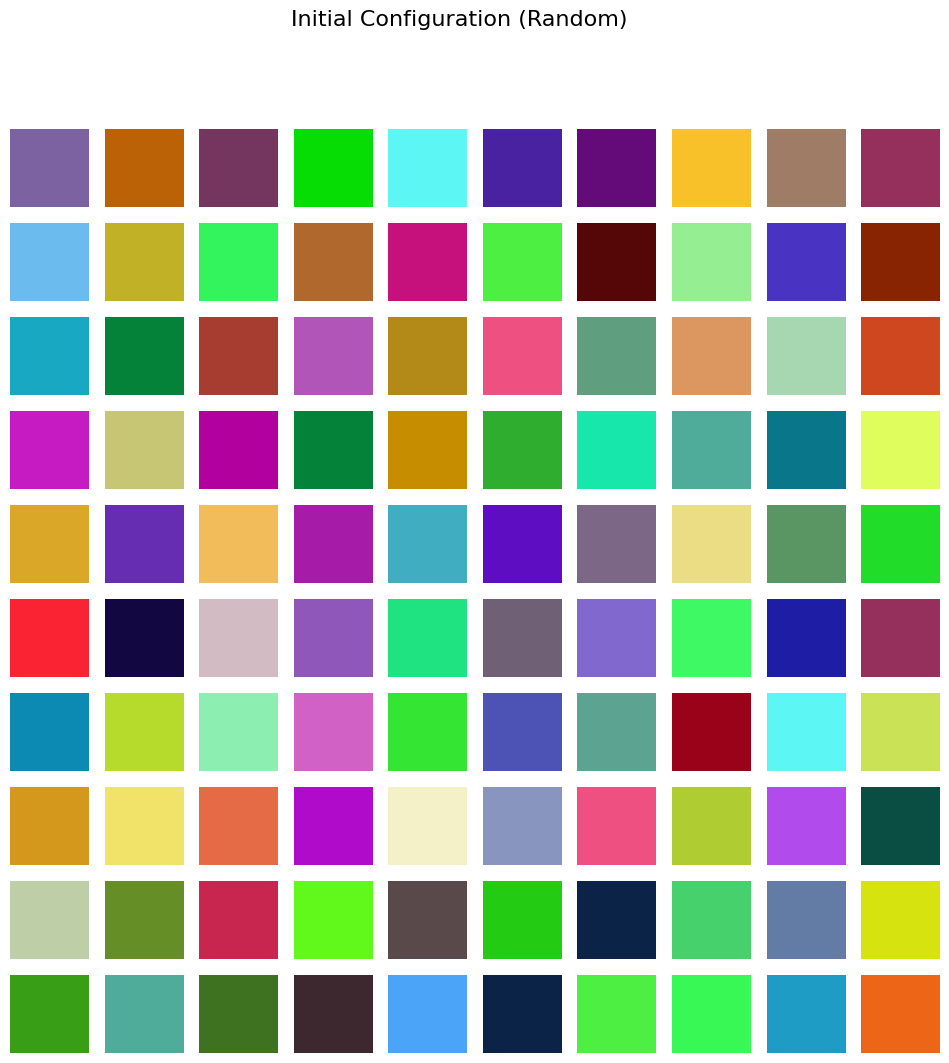

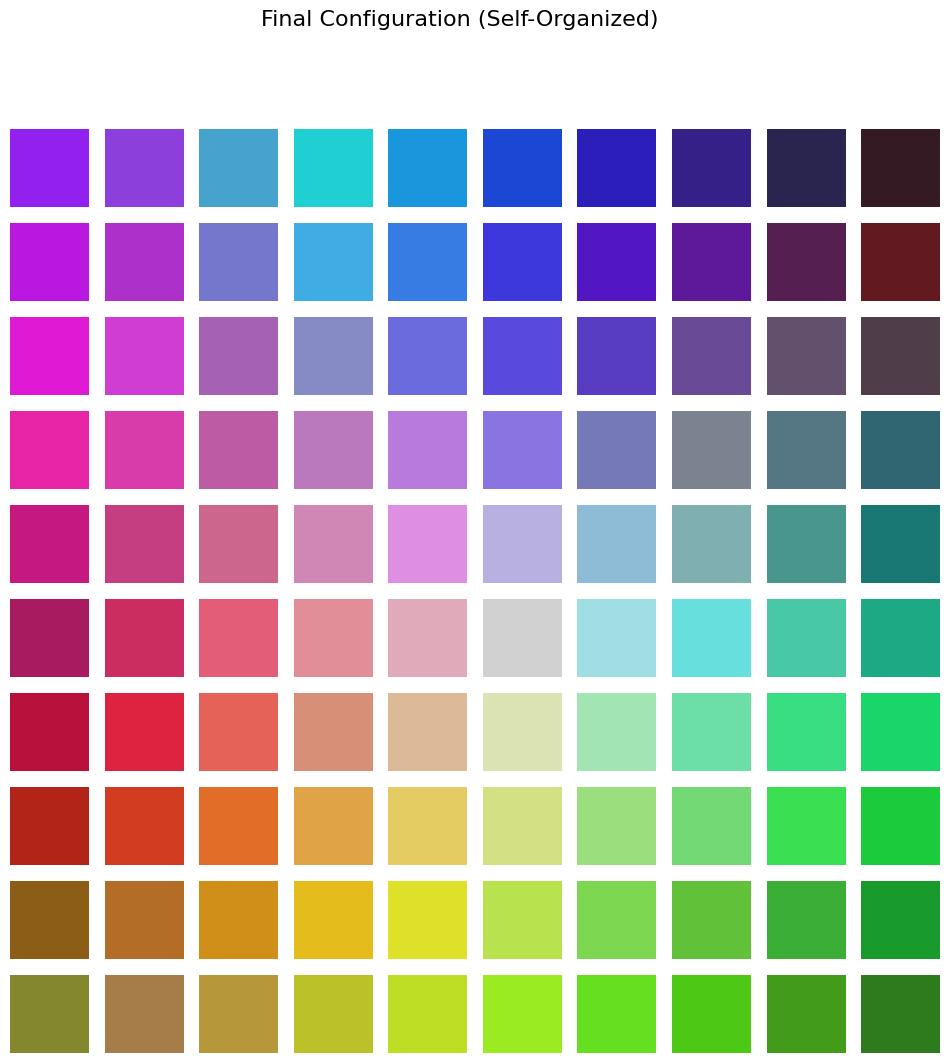

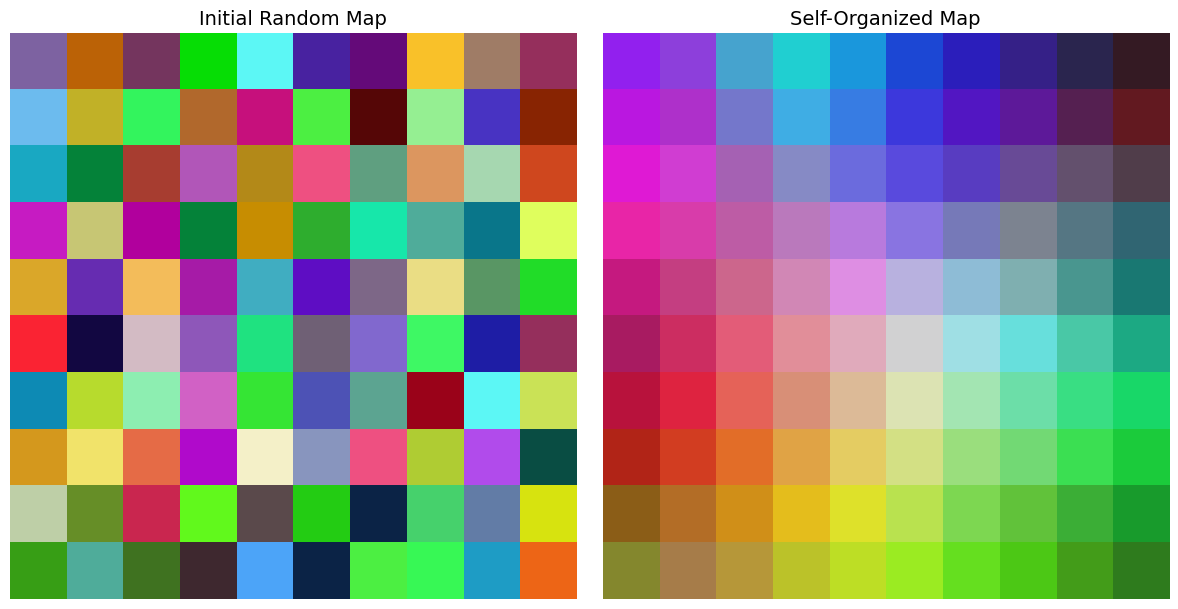

In [12]:
def visualize_som_color_grid(som_size=10, n_iterations=2000, seed=RANDOM_SEED):
    """
    Visualize how SOMs self-organize using random colors as an example.
    
    Parameters:
    -----------
    som_size : int
        Size of the SOM grid (som_size x som_size)
    n_iterations : int
        Number of training iterations
    seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple
        Initial and final weights
    """
    # Generate random colors
    np.random.seed(seed)
    colors = np.random.rand(1000, 3)  # 1000 colors with RGB components
    
    # Create and train the SOM
    som = MiniSom(
        x=som_size, 
        y=som_size, 
        input_len=3, 
        sigma=1.5, 
        learning_rate=0.5, 
        random_seed=seed
    )
    som.random_weights_init(colors)
    initial_weights = som.get_weights().copy()
    som.train_random(colors, n_iterations)
    final_weights = som.get_weights()
    
    # Helper function to plot color grids
    def plot_colors(colors, title):
        plt.figure(figsize=(12, 12))
        for i, color in enumerate(colors.reshape(-1, 3)):
            plt.subplot(som_size, som_size, i+1)
            plt.imshow([[color]])
            plt.axis('off')
        plt.suptitle(title, fontsize=16)
    
    # Plot initial and final configurations
    plot_colors(initial_weights, 'Initial Configuration (Random)')
    plot_colors(final_weights, 'Final Configuration (Self-Organized)')
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(initial_weights.reshape(som_size, som_size, 3))
    plt.title('Initial Random Map', fontsize=14)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(final_weights.reshape(som_size, som_size, 3))
    plt.title('Self-Organized Map', fontsize=14)
    plt.axis('off')
    
    plt.tight_layout()
    
    return initial_weights, final_weights

# Demonstrate SOM self-organization with colors
init_weights, final_weights = visualize_som_color_grid(10, 2000)

Now let's train a SOM on our molecular fingerprints and evaluate its performance.
We'll use cross-validation to find the best hyperparameters for our SOM.


In [ ]:
def train_and_evaluate_som(fingerprints, base_settings=None, param_grid=None):
    """
    Train and evaluate a SOM using cross-validation.
    
    Parameters:
    -----------
    fingerprints : numpy.ndarray
        Molecular fingerprints
    base_settings : dict
        Base settings for the SOM
    param_grid : dict
        Parameter grid for cross-validation
        
    Returns:
    --------
    dict
        Best parameter settings
    """
    # Split data into training and testing sets
    fingerprints_train, fingerprints_test = train_test_split(fingerprints, test_size=0.2)
    
    # Define base settings if not provided
    if base_settings is None:
        base_settings = {
            'x': math.ceil(math.sqrt(5 * math.sqrt(fingerprints.shape[0]))),  # Heuristic for grid size
            'y': math.ceil(math.sqrt(5 * math.sqrt(fingerprints.shape[0]))),
            'input_len': fingerprints.shape[1],
            'neighborhood_function': 'gaussian',
            'random_seed': RANDOM_SEED,
            'topology': 'rectangular',
        }
    
    # Define parameter grid if not provided
    if param_grid is None:
        param_grid = {
            'sigma': [0.5, 1, 1.5, 2, 3, 5],
            'learning_rate': [0.5, 1],
            'activation_distance': ['euclidean', 'cosine']
        }
    
    print(f"Base settings: {base_settings}")
    print(f"Parameter grid: {param_grid}")
    print(f"Grid size: {base_settings['x']}x{base_settings['y']}")
    
    # Perform grid search
    best_setting = (None, np.inf)
    results = []
    
    for values in itertools.product(*param_grid.values()):
        point = dict(zip(param_grid.keys(), values))
        settings = {**base_settings, **point}
        
        try:
            # Create and train SOM
            som = MiniSom(**settings)
            som.train(fingerprints_train, 5000)
            
            # Evaluate SOM
            topographic_error = som.topographic_error(fingerprints_test)
            quantization_error = som.quantization_error(fingerprints_test)
            
            results.append({
                'params': point,
                'topographic_error': topographic_error,
                'quantization_error': quantization_error
            })
            
            print(f"Parameters: {point}\nTopographic Error: {topographic_error:.4f}\nQuantization Error: {quantization_error:.4f}\n")
            
            if topographic_error < best_setting[1]:
                best_setting = (settings, topographic_error)
        
        except Exception as e:
            print(f"Error with parameters {point}: {str(e)}")
    
    print(f"\nBest Parameter Setting: {best_setting[0]}")
    print(f"Best Topographic Error: {best_setting[1]:.4f}")
    
    # Create a dataframe with results for easy analysis
    results_df = pd.DataFrame(results)
    
    return best_setting[0], results_df

# Define SOM base settings and parameter grid
som_base_settings = {
    'x': math.ceil(math.sqrt(5 * math.sqrt(fingerprints.shape[0]))),  # 16
    'y': math.ceil(math.sqrt(5 * math.sqrt(fingerprints.shape[0]))),  # 16
    'input_len': fingerprints.shape[1],
    'neighborhood_function': 'gaussian',
    'random_seed': RANDOM_SEED,
    'topology': 'rectangular',
}

som_param_grid = {
    'sigma': [0.5, 1, 1.5, 2, 3, 5],
    'learning_rate': [0.5, 1],
    'activation_distance': ['euclidean', 'cosine']  # Can also pass in custom, callable distance function 
}

# Train and evaluate SOM (commented out to save time, approximately 15 minutes)
# best_som_params, som_results = train_and_evaluate_som(
#     fingerprints, 
#     base_settings=som_base_settings,
#     param_grid=som_param_grid
# )

# For demonstration, we'll use pre-selected parameters
best_som_params = {
    'x': math.ceil(math.sqrt(5 * math.sqrt(fingerprints.shape[0]))),  # 16
    'y': math.ceil(math.sqrt(5 * math.sqrt(fingerprints.shape[0]))),  # 16
    'input_len': fingerprints.shape[1],
    'sigma': 5,
    'learning_rate': 0.5,
    'neighborhood_function': 'gaussian',
    'random_seed': RANDOM_SEED,
    'topology': 'rectangular',
    'activation_distance': 'cosine'
}

Base settings: {'x': 16, 'y': 16, 'input_len': 2048, 'neighborhood_function': 'gaussian', 'random_seed': 42, 'topology': 'rectangular'}
Parameter grid: {'sigma': [0.5, 1, 1.5, 2, 3, 5], 'learning_rate': [0.5, 1], 'activation_distance': ['euclidean', 'cosine']}
Grid size: 16x16
Parameters: {'sigma': 0.5, 'learning_rate': 0.5, 'activation_distance': 'euclidean'}
Topographic Error: 0.6925
Quantization Error: 4.7569

Parameters: {'sigma': 0.5, 'learning_rate': 0.5, 'activation_distance': 'cosine'}
Topographic Error: 0.4770
Quantization Error: 4.6990

Parameters: {'sigma': 0.5, 'learning_rate': 1, 'activation_distance': 'euclidean'}
Topographic Error: 0.7893
Quantization Error: 4.7084

Parameters: {'sigma': 0.5, 'learning_rate': 1, 'activation_distance': 'cosine'}
Topographic Error: 0.7070
Quantization Error: 4.8065

Parameters: {'sigma': 1, 'learning_rate': 0.5, 'activation_distance': 'euclidean'}
Topographic Error: 0.2712
Quantization Error: 4.2668

Parameters: {'sigma': 1, 'learning_rate

Let's train a SOM with our best parameters and monitor the error metrics during training.

Figure saved as figures/ch07/som_training_errors.png
Figure saved as figures/ch07/som_training_errors.pdf


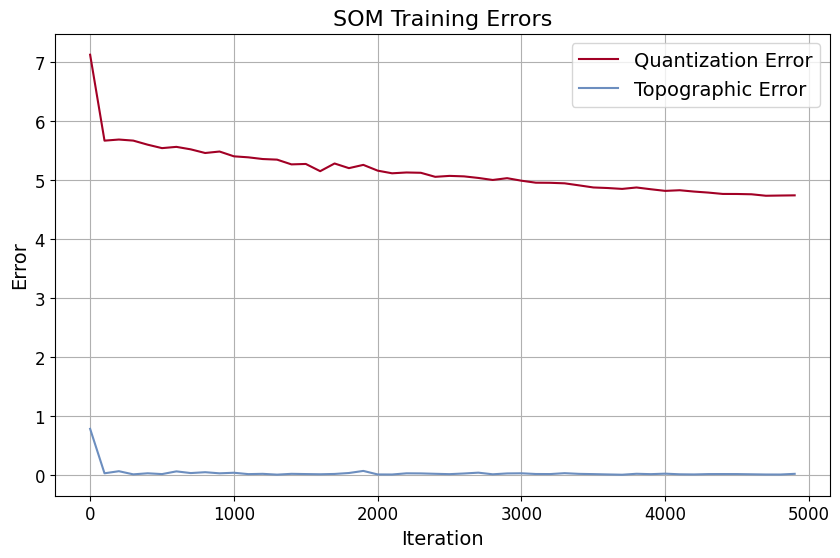

In [14]:
def train_som_with_monitoring(fingerprints, som_params, max_iter=5000, monitor_interval=100):
    """
    Train a SOM and monitor error metrics during training.
    
    Parameters:
    -----------
    fingerprints : numpy.ndarray
        Molecular fingerprints
    som_params : dict
        Parameters for the SOM
    max_iter : int
        Maximum number of iterations
    monitor_interval : int
        Interval for monitoring errors
        
    Returns:
    --------
    MiniSom
        Trained SOM
    dict
        Training history
    """
    # Initialize SOM
    som = MiniSom(**som_params)
    
    # Initialize monitoring
    history = {
        'iterations': [],
        'quantization_error': [],
        'topographic_error': []
    }
    
    # Train SOM with monitoring
    for i in range(max_iter):
        rand_i = np.random.randint(len(fingerprints))
        som.update(fingerprints[rand_i], som.winner(fingerprints[rand_i]), i, max_iter)
        
        if i % monitor_interval == 0:
            history['iterations'].append(i)
            history['quantization_error'].append(som.quantization_error(fingerprints))
            history['topographic_error'].append(som.topographic_error(fingerprints))
    
    # Plot training history
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(history['iterations'], history['quantization_error'], label='Quantization Error')
    ax.plot(history['iterations'], history['topographic_error'], label='Topographic Error')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Error')
    ax.set_title('SOM Training Errors')
    ax.legend()
    ax.grid(True)
    save_figure(fig, 'som_training_errors')
    
    return som, history

# Train SOM with monitoring
som, training_history = train_som_with_monitoring(fingerprints, best_som_params)

Let's visualize our SOM to understand the distribution of active and inactive compounds across the map.

**Code for Figure 7.4.** (Left) Visualize the proportion of compounds per class that reside in a specific node. We observe that nodes in the top right and top left quadrants are most enriched for active and inactive compounds, respectively. (Right) . The UMAT represents the average distance between a node and its neighbors by color: areas with lighter colors (lower values) indicate that the nodes are close to each other, suggesting a cluster of similar data points that preserves the topology of the high-dimensional training data.

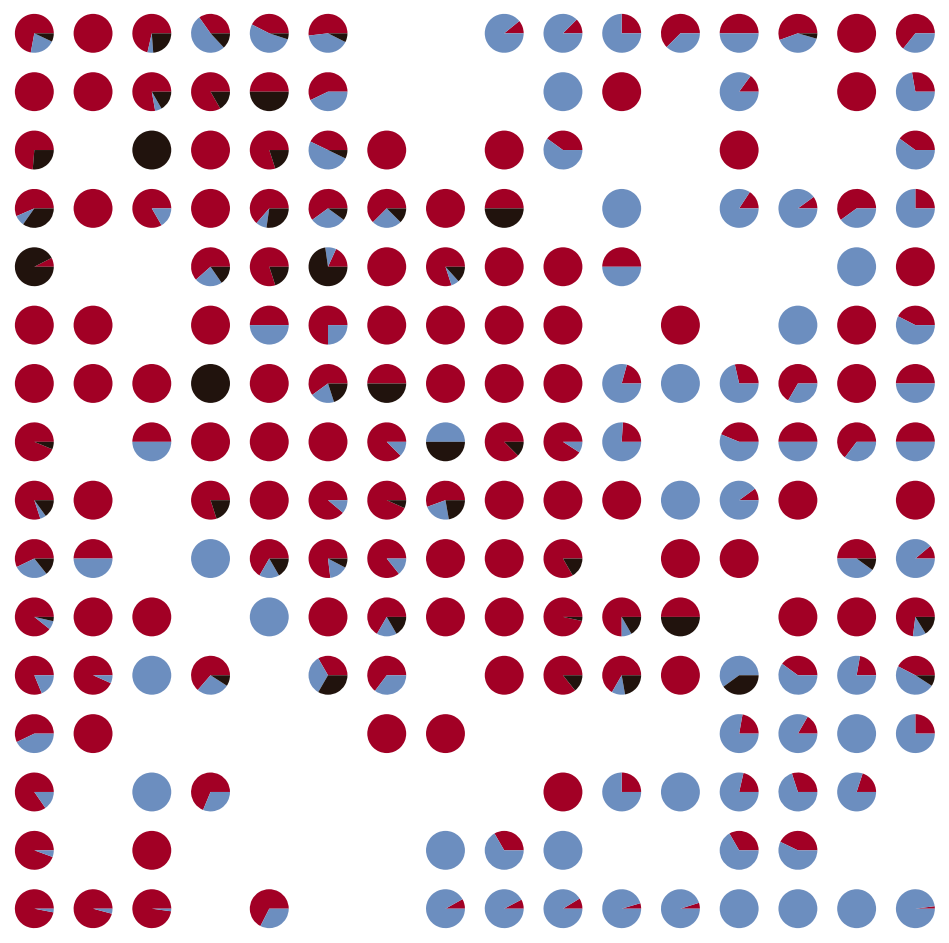

In [ ]:
labels_map = som.labels_map(fingerprints, [label_names[t] for t in target])
target = data['label'].values
colors = ["#A20025", "#6C8EBF", "#21130d"]
n_nodes, m_nodes = 16, 16

fig = plt.figure(figsize=(12, 12))
the_grid = gridspec.GridSpec(n_nodes, m_nodes, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_nodes-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

In [ ]:
from matplotlib import cm
import plotly.graph_objects as go

# Adapted from https://github.com/JustGlowing/minisom/blob/master/examples/AdvancedVisualization.ipynb
def findMin(x, y, umat):
    newxmin=max(0,x-1)
    newxmax=min(umat.shape[0],x+2)
    newymin=max(0,y-1)
    newymax=min(umat.shape[1],y+2)
    minx, miny = np.where(umat[newxmin:newxmax,newymin:newymax] == umat[newxmin:newxmax,newymin:newymax].min())
    return newxmin+minx[0], newymin+miny[0]

def findInternalNode(x, y, umat):
    minx, miny = findMin(x,y,umat)
    if (minx == x and miny == y):
        cx = minx
        cy = miny
    else:
        cx,cy = findInternalNode(minx,miny,umat)
    return cx, cy

def matplotlib_cmap_to_plotly(cmap, entries):
    h = 1.0/(entries-1)
    colorscale = []

    for k in range(entries):
        C = (np.array(cmap(k*h)[:3])*255)
        colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return colorscale

def plotStarburstMap(som):
    boner_rgb = []
    norm = matplotlib.colors.Normalize(vmin=0, vmax=255)
    bone_r_cmap = matplotlib.cm.get_cmap('bone_r')

    bone_r = matplotlib_cmap_to_plotly(bone_r_cmap, 255)

    layout = go.Layout()
    fig = go.Figure(layout=layout)
    fig.add_trace(go.Heatmap(z=som.distance_map().T, colorscale=bone_r))
    shapes=[]

    for row in np.arange(som.distance_map().shape[0]):
        for col in np.arange(som.distance_map().shape[1]):
            cx,cy = findInternalNode(row, col, som.distance_map().T)
            shape=go.layout.Shape(
                    type="line",
                    x0=row,
                    y0=col,
                    x1=cx,
                    y1=cy,
                    line=dict(
                        color="Black",
                        width=1
                    )
                )
            shapes=np.append(shapes, shape)

    fig.update_layout(shapes=shapes.tolist(), 
        width=500,
        height=500) 
    fig.show()
    
plotStarburstMap(som)

/tmp/ipykernel_9317/1523375579.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bone_r_cmap = matplotlib.cm.get_cmap('bone_r')


### <b> <font color='#A20025'> Drug Repurposing Analysis

Now that we have trained a SOM, we can use it for drug repurposing by mapping compounds from the Drug Repurposing Hub 
to our trained SOM and identifying those that map to regions with known active compounds.

In [ ]:
def load_drug_repurposing_data(file_path):
    """
    Load and process data from the Drug Repurposing Hub.
    
    Parameters:
    -----------
    file_path : str
        Path to the drug repurposing data
        
    Returns:
    --------
    pandas.DataFrame
        Processed drug repurposing data
    """
    try:
        # Load the data
        print(f"Loading drug repurposing data from {file_path}...")
        drh_data = pd.read_csv(file_path)
        
        # Drop rows with missing values
        drh_data = drh_data.dropna()
        
        # Generate Morgan fingerprints
        print("Computing Morgan fingerprints for repurposing candidates...")
        drh_data['Morgan_Fingerprint'] = drh_data['smiles'].apply(generate_morgan_fingerprint)
        
        # Drop rows with invalid fingerprints
        drh_data = drh_data.dropna(subset=['Morgan_Fingerprint'])
        print(f"Valid molecules after processing: {len(drh_data)}")
        
        return drh_data
    
    except Exception as e:
        print(f"Error loading drug repurposing data: {str(e)}")
        raise

def identify_repurposing_candidates(som, trained_data, repurposing_data, retrospective_hits_list):
    """
    Identify drug repurposing candidates using a trained SOM.
    
    Parameters:
    -----------
    som : MiniSom
        Trained SOM
    trained_data : pandas.DataFrame
        Data used to train the SOM
    repurposing_data : pandas.DataFrame
        Data containing potential repurposing candidates
    retrospective_hits_list : list
        List of known retrospective hits for validation
        
    Returns:
    --------
    pandas.DataFrame
        Repurposing data with predictions
    list
        Captured retrospective hits
    """
    # Convert fingerprints to numpy array
    unseen_fingerprints = np.array([list(fp) for fp in repurposing_data['Morgan_Fingerprint']])
    
    # Label each SOM node based on the majority label from training data
    def majority_label(labels):
        return np.argmax(np.bincount(labels))
    
    # Map training data to SOM nodes
    win_map = som.win_map(fingerprints, return_indices=True)
    
    # Determine the majority label for each node
    node_labels = {}
    for position, instances in win_map.items():
        instance_labels = [trained_data['label'].iloc[idx] for idx in instances]
        node_labels[position] = majority_label(instance_labels)
    
    # Predict activity for each repurposing candidate
    predicted_activities = []
    for fingerprint in unseen_fingerprints:
        winner_node = som.winner(fingerprint)
        predicted_activity = node_labels.get(winner_node, None)
        predicted_activities.append(predicted_activity)
    
    # Add predictions to the dataframe
    repurposing_data['predicted_label'] = predicted_activities
    repurposing_data['predicted_activity'] = repurposing_data.predicted_label.map(label_names)
    
    # Identify retrospective hits captured by the model
    drh_compounds = set(repurposing_data['pert_iname'].tolist())
    retrospective_hits_in_drh = [x for x in retrospective_hits_list if x in drh_compounds]
    
    predicted_hits = set(
        repurposing_data[repurposing_data['predicted_activity'] == 'Active']['pert_iname'].tolist()
    )
    
    captured_hits = [x for x in retrospective_hits_in_drh if x in predicted_hits]
    
    # Print evaluation metrics
    print(f"Total compounds analyzed: {len(repurposing_data)}")
    print(f"Predicted active compounds: {len(predicted_hits)}")
    print(f"Retrospective hits in data: {len(retrospective_hits_in_drh)}")
    print(f"Captured retrospective hits: {len(captured_hits)}")
    
    if retrospective_hits_in_drh:
        success_rate = len(captured_hits) / len(retrospective_hits_in_drh)
        print(f"Success rate: {success_rate:.2f}")
    
    return repurposing_data, captured_hits

# Define retrospective hits based on literature
retrospective_hits = set([
    'atpenin a5', 'tinostamustine', 'chloroquine', 'hydroxychloroquine',
    'remdesivir', 'favipiravir', 'ribavirin', 'oseltamivir', 'umifenovir',
    'lopinavir', 'ritonavir', 'ivermectin', 'bananins', 'nafamostat',
    'imatinib', 'corticosteroid', 'baricitinib', 'azithromycin', 'losartan',
    'telmisartan', 'nelfinavir', 'prulifloxacin', 'tegobuvir', 'bictegravir'
])

# Load drug repurposing data
drh_data = load_drug_repurposing_data('data/ch07/raw/CH07_drug_repurposing_hub.csv')

# Identify repurposing candidates
predictions, captured_hits = identify_repurposing_candidates(
    som, data, drh_data, retrospective_hits
)

Loading drug repurposing data from data/ch07/raw/CH07_drug_repurposing_hub.csv...
Computing Morgan fingerprints for repurposing candidates...
Error generating fingerprint for CN1[C@H]2CC[C@@H]1C[C@@H](C2)O[C@H](c1ccccc1)c1ccc(Cl)cc1 |&1:2,5,7,&2:10,r,THB:0:1:3.4:6.7.8|: Could not parse SMILES: CN1[C@H]2CC[C@@H]1C[C@@H](C2)O[C@H](c1ccccc1)c1ccc(Cl)cc1 |&1:2,5,7,&2:10,r,THB:0:1:3.4:6.7.8|
Error generating fingerprint for OC\C=C1/C[N@+]2(CC=C)CC[C@@]34[C@@H]2C[C@@H]1\C1=C\N2[C@@H]5\C(=C/N([C@@H]31)c1ccccc41)[C@H]1C[C@H]3[C@@]5(CC[N@@+]3(CC=C)C\C1=C/CO)c1ccccc21 |a:5,11,12,14,29,31,32,35,&1:18,&2:22,c:21,t:17,TLB:2:3:13:11.15.22,20:19:30:35.39.40,10:11:3.4.5:13,41:40:30:18.19.32,28:11:3.4.5:13,THB:34:35:30:18.19.32,16:15:3.4.5:13,33:32:30:35.39.40,36:35:30:18.19.32,6:5:13:11.15.22,9:5:13:11.15.22,44:32:30:35.39.40|: Could not parse SMILES: OC\C=C1/C[N@+]2(CC=C)CC[C@@]34[C@@H]2C[C@@H]1\C1=C\N2[C@@H]5\C(=C/N([C@@H]31)c1ccccc41)[C@H]1C[C@H]3[C@@]5(CC[N@@+]3(CC=C)C\C1=C/CO)c1ccccc21 |a:5,11,12

In [19]:
# Display captured hits
print("\nCaptured retrospective hits:")
for hit in sorted(captured_hits):
    print(f"- {hit}")


Captured retrospective hits:
- atpenin a5
- azithromycin
- bictegravir
- chloroquine
- favipiravir
- hydroxychloroquine
- imatinib
- ivermectin
- lopinavir
- losartan
- nafamostat
- nelfinavir
- ribavirin
- tegobuvir
- telmisartan
- tinostamustine


In [23]:
print(f"Success Rate: {len(captured_hits)/len(retrospective_hits)}")

Success Rate: 0.6666666666666666


In [25]:
predictions.predicted_activity.value_counts()

predicted_activity
Active      5537
Unknown      472
Inactive     217
Name: count, dtype: int64

In [27]:
data['label'].value_counts()

label
1    1144
2     782
3     136
Name: count, dtype: int64

### <b> <font color='#A20025'> Universal Manifold Approximation & Projection (UMAP)

UMAP is another dimensionality reduction technique that is particularly good at preserving both local and global structure.
Let's compare UMAP with PCA on a standard dataset (the Swiss Roll) to demonstrate its capabilities.

/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Figure saved as figures/ch07/dimensionality_reduction_comparison.png
Figure saved as figures/ch07/dimensionality_reduction_comparison.pdf


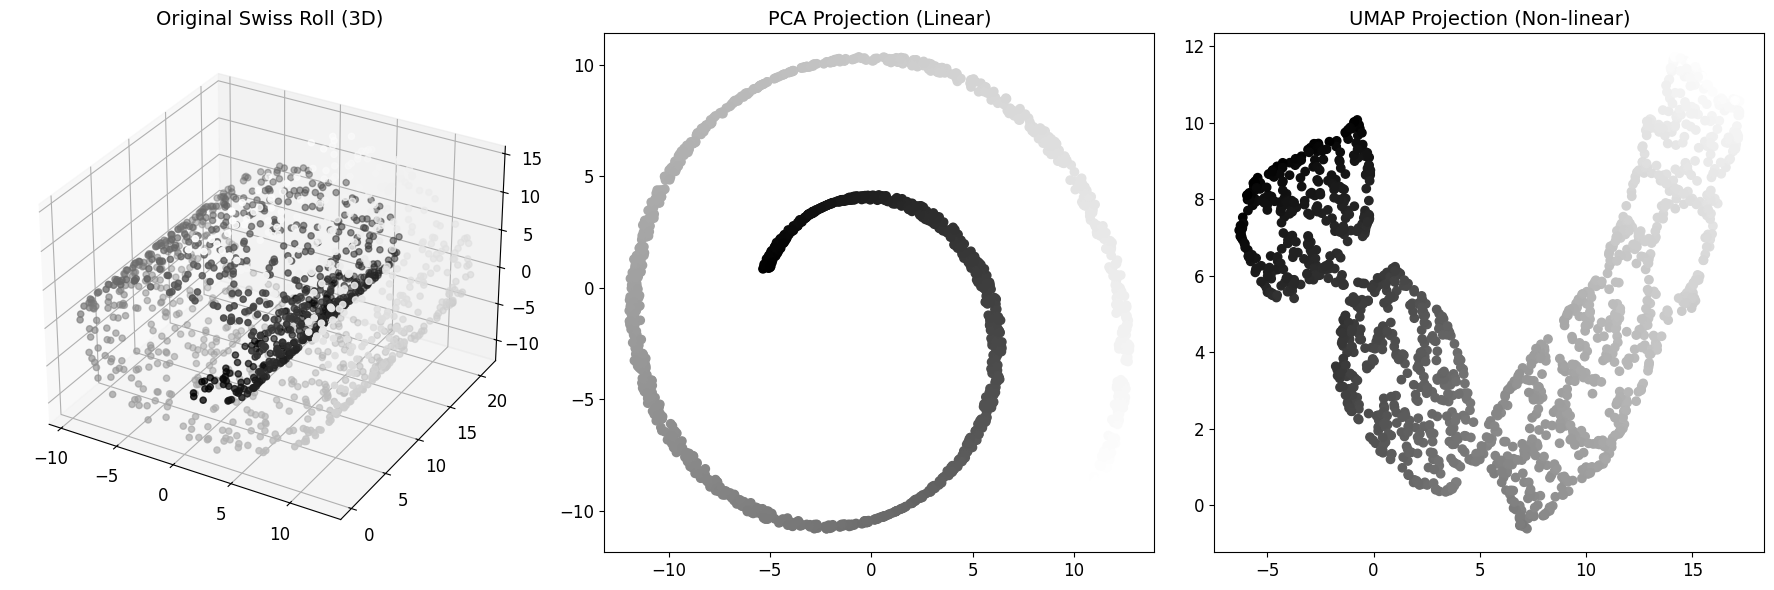

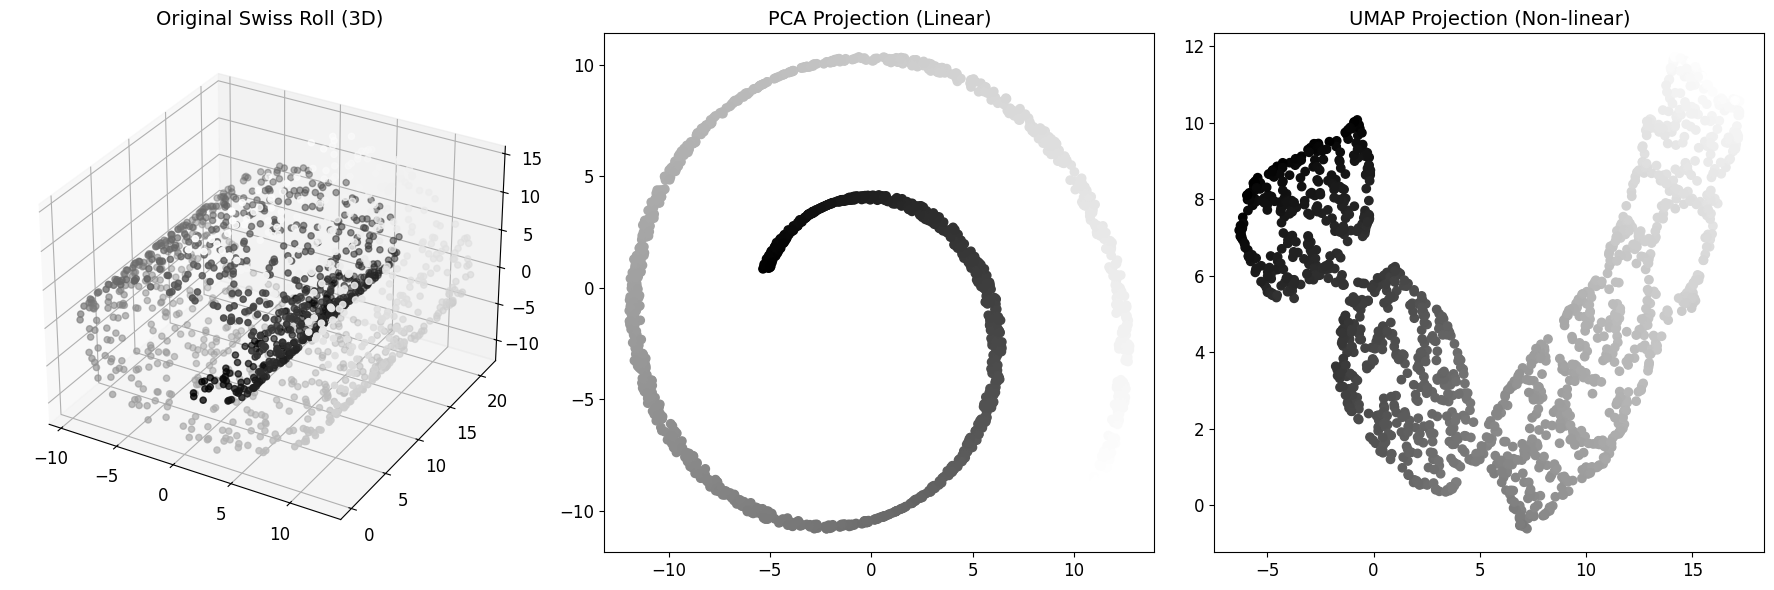

In [28]:
def compare_dimensionality_reduction_techniques(n_samples=1500, random_state=RANDOM_SEED):
    """
    Compare different dimensionality reduction techniques on the Swiss Roll dataset.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples in the dataset
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure with the comparison
    """
    # Generate Swiss Roll dataset
    X, color = make_swiss_roll(n_samples=n_samples, random_state=random_state)
    grayscale = (color - color.min()) / (color.max() - color.min())
    
    # Apply dimensionality reduction techniques
    # 1. PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # 2. UMAP
    reducer = umap.UMAP(
        n_components=2, 
        n_neighbors=30, 
        min_dist=0.3, 
        random_state=random_state
    )
    X_umap = reducer.fit_transform(X)
    
    # 3. Locally Linear Embedding (LLE)
    X_lle, _ = locally_linear_embedding(
        X, n_neighbors=12, n_components=2
    )
    
    # Create visualization
    fig = plt.figure(figsize=(18, 6))
    
    # Original 3D data
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=grayscale, cmap='gray')
    ax.set_title("Original Swiss Roll (3D)", fontsize=14)
    
    # PCA projection
    ax = fig.add_subplot(132)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=grayscale, cmap='gray')
    ax.set_title("PCA Projection (Linear)", fontsize=14)
    
    # UMAP projection
    ax = fig.add_subplot(133)
    ax.scatter(X_umap[:, 0], X_umap[:, 1], c=grayscale, cmap='gray')
    ax.set_title("UMAP Projection (Non-linear)", fontsize=14)
    
    plt.tight_layout()
    save_figure(fig, 'dimensionality_reduction_comparison')
    
    return fig

# Compare dimensionality reduction techniques
compare_dimensionality_reduction_techniques()

**Code for Figure 7.5.** Comparison of PCA to a more complex manifold learning algorithm on the Swiss Roll data set.

/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


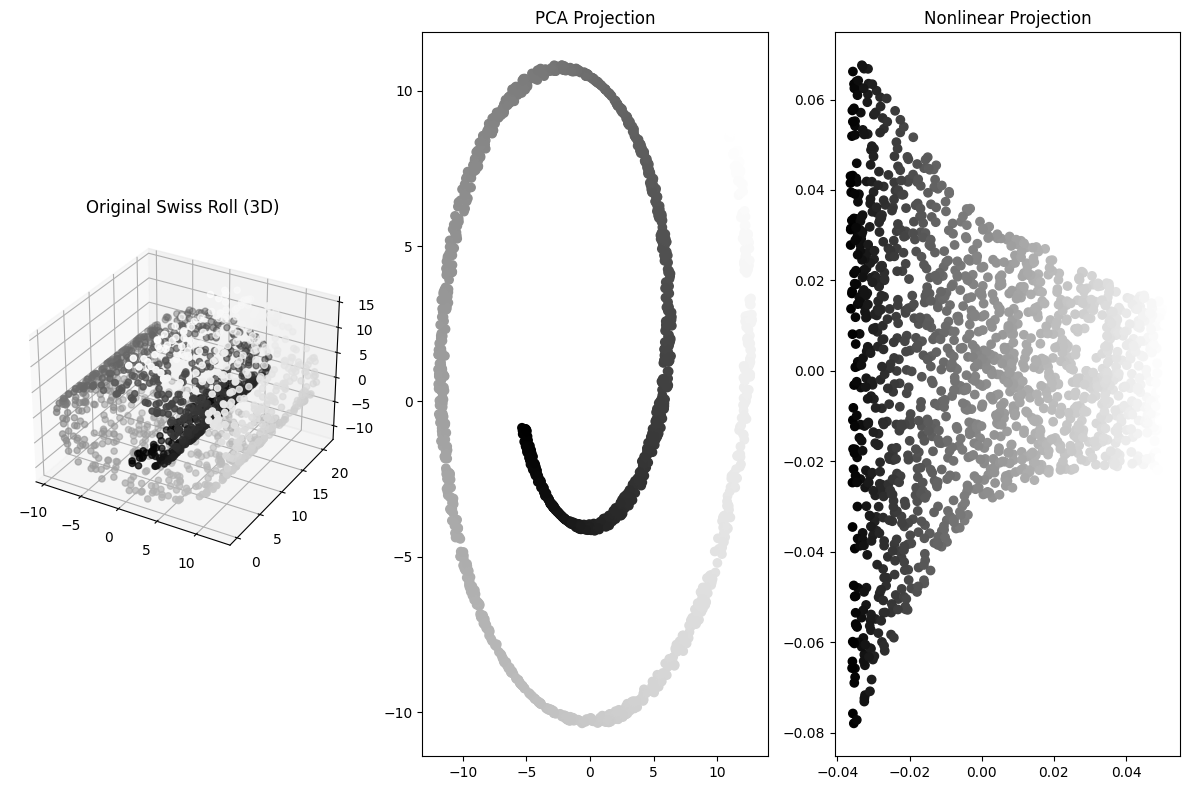

In [3]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import locally_linear_embedding

n_samples = 1500
X, color = make_swiss_roll(n_samples=n_samples, random_state=RANDOM_SEED)
grayscale = (color - color.min()) / (color.max() - color.min())

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
X_umap = reducer.fit_transform(X)

X_lle, _ = locally_linear_embedding(
    X, n_neighbors=12, n_components=2
)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=grayscale, cmap='gray')
ax.set_title("Original Swiss Roll (3D)")

ax = fig.add_subplot(132)
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=grayscale, cmap='gray')
ax.set_title("PCA Projection")

ax = fig.add_subplot(133)
scatter = ax.scatter(X_lle[:, 0], X_lle[:, 1], c=grayscale, cmap='gray')
ax.set_title("Nonlinear Projection")

plt.tight_layout()
plt.savefig('figures/ch07/swiss_roll_visual.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch07/swiss_roll_visual.pdf', bbox_inches='tight', dpi=600);

We apply UMAP to our drug discovery dataset to see how it differs from SOM.

In [29]:
def optimize_umap_parameters(train_fps, train_labels, test_fps=None, test_labels=None):
    """
    Optimize UMAP parameters using cross-validation.
    
    Parameters:
    -----------
    train_fps : numpy.ndarray
        Training fingerprints
    train_labels : numpy.ndarray
        Training labels
    test_fps : numpy.ndarray, optional
        Testing fingerprints
    test_labels : numpy.ndarray, optional
        Testing labels
        
    Returns:
    --------
    dict
        Best UMAP parameters
    """
    # Define parameter grid
    umap_params = {
        'umap__n_neighbors': [5, 10, 15],
        'umap__min_dist': [0.1, 0.2, 0.3]
    }
    
    # Create pipeline
    pipeline = Pipeline([
        ('umap', umap.UMAP(metric="jaccard", n_components=2)),
        ('knn', KNeighborsClassifier(n_neighbors=5)),
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(
        pipeline, 
        umap_params, 
        cv=3, 
        scoring='f1_micro', 
        n_jobs=-1
    )
    
    # Convert binary labels if needed
    if isinstance(train_labels[0], bool):
        train_labels = train_labels.astype(int)
    
    # Fit the grid search
    grid_search.fit(train_fps, train_labels)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Train the model with the best parameters
    best_model = grid_search.best_estimator_
    
    # Evaluate on test set if provided
    if test_fps is not None and test_labels is not None:
        test_score = best_model.score(test_fps, test_labels)
        print(f"Test score: {test_score:.4f}")
    
    return best_model, grid_search.best_params_

In [ ]:
# Prepare data for UMAP
train_labels = (data["label"] == 1).values  # Active vs. non-active
drh_data["retro_hit"] = drh_data.pert_iname.isin(retrospective_hits)
test_labels = drh_data["retro_hit"].values
train_fps = fingerprints
test_fps = np.array([list(fp) for fp in drh_data['Morgan_Fingerprint']])

# Find optimal UMAP parameters (commented out to save time, approximately 8 minutes)
# best_umap_model, best_params = optimize_umap_parameters(train_fps, train_labels)

# For demonstration, we'll use pre-selected parameters
best_umap_model = Pipeline([
    ('umap', umap.UMAP(
        n_components=2,
        n_neighbors=10,
        min_dist=0.2,
        metric="jaccard",
        random_state=RANDOM_SEED
    )),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])
best_umap_model.fit(train_fps, train_labels)

/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_a

Best parameters: {'umap__min_dist': 0.2, 'umap__n_neighbors': 10}
Best cross-validation score: 0.6299


**Code for Figure 7.7.** UMAP projection across each COVID Moonshot compound’s activity (left) and chemical series designation (right).

/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



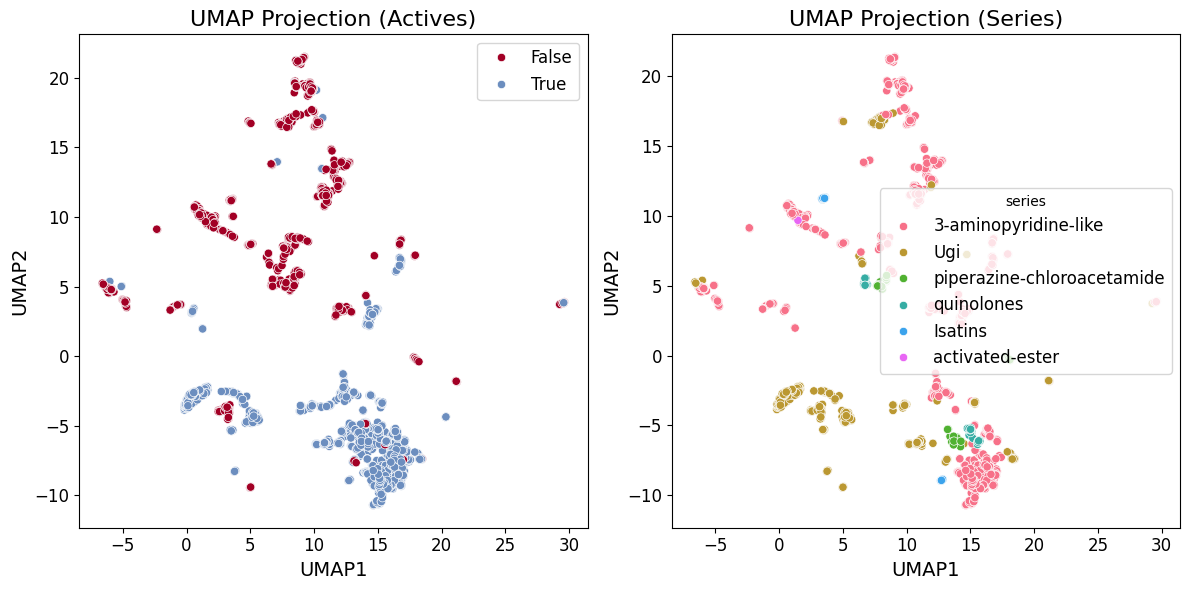

In [35]:
umap_model = best_umap_model.named_steps['umap']
train_embedding = umap_model.transform(train_fps)

def plot_embedding(embedding, labels, title):
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels)
    plt.title(title)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')

# Visualize the UMAP embeddings
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_embedding(train_embedding, train_labels, 'UMAP Projection (Actives)')

plt.subplot(1, 2, 2)
plot_embedding(train_embedding, data['series'], 'UMAP Projection (Series)')

plt.tight_layout()
plt.savefig('figures/ch07/umap_projections.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch07/umap_projections.pdf', bbox_inches='tight', dpi=600);

## <b> <font color='#A20025'>  2️⃣ Clustering: Curating Diverse Compound Libraries

This section explores clustering techniques for designing diverse and focused chemical libraries.
We'll examine combinatorial library design and various clustering methods to create balanced compound collections.


### <b> <font color='#A20025'> Data Preparation

First, let's load our activity data for clustering.

In [36]:
def load_data_for_clustering(file_path):
    """
    Load data for clustering analysis.
    
    Parameters:
    -----------
    file_path : str
        Path to the activity data CSV
        
    Returns:
    --------
    pandas.DataFrame
        Loaded data with RDKit molecule objects
    """
    try:
        # Load the data
        print(f"Loading data from {file_path}...")
        data = pd.read_csv(file_path)
        
        # Convert SMILES to molecule objects
        data['mol'] = data['SMILES'].apply(Chem.MolFromSmiles)
        
        # Remove entries with invalid molecules
        valid_mol_count = sum(mol is not None for mol in data['mol'])
        print(f"Valid molecules: {valid_mol_count} / {len(data)}")
        
        if valid_mol_count < len(data):
            data = data[data['mol'].notnull()]
            print(f"Retained {len(data)} valid molecules")
        
        return data
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

# Try to use the previously loaded data or load again if needed
if 'data' not in globals() or 'mol' not in data.columns:
    data = load_data_for_clustering('data/ch07/raw/CH07_activity_data.csv')

Loading data from data/ch07/raw/CH07_activity_data.csv...
Valid molecules: 2062 / 2062


### <b> <font color='#A20025'> Combinatorial Libraries

#### <b> <font color='#A20025'>  Combinatorial Library Design

Combinatorial library design involves generating new compounds by combining molecular fragments.
Here, we'll demonstrate two approaches:
1. Core-based combinatorial library design
2. Retrosynthetic fragment-based approach


In [37]:
def extract_cores_and_fragments(molecules):
    """
    Extract molecular cores (scaffolds) and fragments from a list of molecules.
    
    Parameters:
    -----------
    molecules : list
        List of RDKit molecule objects
        
    Returns:
    --------
    tuple
        Lists of core SMILES and fragment SMILES
    """
    cores, frags = [], []
    
    for mol in molecules:
        if mol is None:
            continue
        
        try:
            # Get Murcko scaffold (core) of the molecule
            bms = MurckoScaffold.GetScaffoldForMol(mol)
            core = Chem.ReplaceSidechains(mol, bms)
            
            # Get fragments (R-groups) by replacing the core in the molecule
            rgroups = Chem.ReplaceCore(mol, bms)
            
            if core is not None:
                cores.append(Chem.MolToSmiles(core))
            
            if rgroups:
                frags.extend(Chem.MolToSmiles(rgroups).split('.'))
        
        except Exception as e:
            print(f"Error processing molecule: {e}")
            continue
    
    # Filter out empty strings and duplicates
    cores = [c for c in cores if c]
    frags = [f for f in frags if f]
    
    # Remove duplicates while preserving order
    unique_cores = []
    for core in cores:
        if core not in unique_cores:
            unique_cores.append(core)
    
    unique_frags = []
    for frag in frags:
        if frag not in unique_frags:
            unique_frags.append(frag)
    
    print(f"Extracted {len(unique_cores)} unique cores and {len(unique_frags)} unique fragments")
    return unique_cores, unique_frags

# Extract cores and fragments
cores, fragments = extract_cores_and_fragments(data['mol'])

Extracted 1617 unique cores and 361 unique fragments


In [40]:
def generate_combinatorial_library(cores, fragments, expansion_factor=5, max_compounds=5000):
    """
    Generate a combinatorial library by combining cores and fragments.
    
    Parameters:
    -----------
    cores : list
        List of core SMILES
    fragments : list
        List of fragment SMILES
    expansion_factor : int
        Number of compounds to generate per core
    max_compounds : int
        Maximum number of compounds to generate
        
    Returns:
    --------
    list
        List of generated RDKit molecule objects
    """
    import random
    
    # Define reaction SMARTS for connecting fragments
    reaction_smirks = "[*:0][#0].[#0][*:1]>>[*:0][*:1]"
    rxn = AllChem.ReactionFromSmarts(reaction_smirks)
    
    new_mols = []
    
    # Loop over each scaffold
    for core_idx, core_smi in enumerate(cores):
        if len(new_mols) >= max_compounds:
            break
        
        print(f"Processing core {core_idx+1}/{len(cores)}: {core_smi[:30]}...")
        
        for _ in range(expansion_factor):
            # Skip if we've reached the maximum number of compounds
            if len(new_mols) >= max_compounds:
                break
            
            # Start with the core
            working_smi = core_smi
            
            # Continue substituting attachment points until none remain
            iterations = 0
            max_iterations = 10  # Prevent infinite loops
            
            while "[*]" in working_smi and iterations < max_iterations:
                # Select a random fragment
                random_idx = random.randint(0, len(fragments)-1)
                random_frag = fragments[random_idx]
                
                try:
                    # Use the reaction SMARTS to connect the fragment
                    reactants = [
                        Chem.MolFromSmiles(working_smi),
                        Chem.MolFromSmiles(random_frag)
                    ]
                    
                    if None in reactants:
                        iterations += 1
                        continue
                    
                    products = rxn.RunReactants(reactants)
                    
                    # Skip if no product is formed
                    if not products or len(products) == 0:
                        iterations += 1
                        continue
                    
                    # Select a random product
                    product_idx = random.randint(0, len(products)-1)
                    working_smi = Chem.MolToSmiles(products[product_idx][0])
                    
                except Exception as e:
                    print(f"Error in reaction: {e}")
                    iterations += 1
                    continue
                
                iterations += 1
            
            # Convert the final SMILES to a molecule and add to the library
            try:
                mol = Chem.MolFromSmiles(working_smi)
                if mol:
                    AllChem.Compute2DCoords(mol)
                    new_mols.append(mol)
            except Exception as e:
                print(f"Error converting final product: {e}")
                continue
    
    print(f"Generated {len(new_mols)} new compounds")
    return new_mols

# Generate combinatorial library
combinatorial_mols = generate_combinatorial_library(cores, fragments, expansion_factor=5, max_compounds=10000)

Processing core 1/1617: [1*]N1CC2(CCN(c3cncc4ccccc34)C...
Processing core 2/1617: [1*]c1ccc2c(c1)C1(CCN(c3cncc4c...
Processing core 3/1617: [1*]C1(N2C[C@]3(CCN(c4cncc5ccc...
Processing core 4/1617: [1*]C1(N2C[C@@]3(CCN(c4cncc5cc...
Processing core 5/1617: [1*]N1C[C@@]2(CCN(c3cncc4ccccc...
Processing core 6/1617: [1*]N1Cc2ccc([2*])cc2C2(CCN(c3...
Processing core 7/1617: [1*]c1ccc2cncc(N3CCC4(CN(S(=O)...
Processing core 8/1617: [1*]C1(CS(=O)(=O)N2Cc3ccc([2*]...
Processing core 9/1617: [1*]C1CN(c2cncc3ccccc23)C(=O)C...
Processing core 10/1617: [1*]n1nccc1C(=O)N1Cc2ccc([2*])...
Processing core 11/1617: [1*]c1ccc2c(c1)C1(CCN(c3cncc4c...
Processing core 12/1617: [1*]c1cnn([2*])c1C(=O)N1Cc2ccc...
Processing core 13/1617: [1*]c1cc(C(=O)N2Cc3ccc([2*])cc...
Processing core 14/1617: [1*]C1(CS(=O)(=O)N2Cc3ccc([2*]...
Processing core 15/1617: [1*]c1ccc2c(c1)[C@@H](C(=O)Nc1...
Processing core 16/1617: [1*]N1Cc2ccc([2*])cc2[C@]2(CCN...
Processing core 17/1617: [1*]N1Cc2ccc([2*])cc2[C@@]2(CC...
Proces

#### <b> <font color='#A20025'> Retrosynthetic Approach

In [41]:
def generate_brics_library(molecules, max_compounds=1000):
    """
    Generate a library using BRICS fragmentation and recombination.
    
    Parameters:
    -----------
    molecules : list
        List of RDKit molecule objects
    max_compounds : int
        Maximum number of compounds to generate
        
    Returns:
    --------
    list
        List of generated RDKit molecule objects
    """
    # Extract BRICS fragments
    frags = set()
    
    for mol in tqdm(molecules, desc="Extracting BRICS fragments"):
        if mol is None:
            continue
        
        try:
            # Decompose molecules into BRICS fragments
            fragments = BRICS.BRICSDecompose(mol)
            frags.update(fragments)
        except Exception as e:
            print(f"Error in BRICS decomposition: {e}")
            continue
    
    print(f"Extracted {len(frags)} unique BRICS fragments")
    
    # Convert fragments to molecules
    frag_mols = []
    for frag in frags:
        try:
            frag_mol = Chem.MolFromSmiles(frag)
            if frag_mol:
                AllChem.Compute2DCoords(frag_mol)
                frag_mols.append(frag_mol)
        except Exception as e:
            print(f"Error converting fragment: {e}")
            continue
    
    print(f"Converted {len(frag_mols)} fragments to molecules")
    
    # Build new molecules from the fragments
    new_mols = []
    try:
        for mol in tqdm(BRICS.BRICSBuild(frag_mols, maxDepth=1), desc="Building molecules"):
            if len(new_mols) >= max_compounds:
                break
            
            try:
                Chem.SanitizeMol(mol)
                AllChem.Compute2DCoords(mol)
                new_mols.append(mol)
            except Exception as e:
                continue
    except Exception as e:
        print(f"Error in BRICS building: {e}")
    
    print(f"Generated {len(new_mols)} new compounds using BRICS")
    return new_mols

# Generate BRICS library
brics_mols = generate_brics_library(data['mol'].tolist(), max_compounds=10000)

Extracting BRICS fragments: 100%|██████████| 2062/2062 [00:20<00:00, 100.57it/s]


Extracted 1388 unique BRICS fragments
Converted 1388 fragments to molecules


Building molecules: 10000it [00:42, 237.16it/s]

Generated 10000 new compounds using BRICS


In [42]:
# Combined library for clustering
library_mols = combinatorial_mols + brics_mols

In [47]:
def visualize_molecule_grid(molecules, n_mols=16, title="Generated Molecules"):
    """
    Visualize a grid of molecules.
    
    Parameters:
    -----------
    molecules : list
        List of RDKit molecule objects
    n_mols : int
        Number of molecules to display
    title : str
        Title for the grid
        
    Returns:
    --------
    rdkit.Chem.Draw._MolsToGridImage
        Grid image of molecules
    """
    # Sample molecules if there are more than n_mols
    if len(molecules) > n_mols:
        import random
        sample_mols = random.sample(molecules, n_mols)
    else:
        sample_mols = molecules
    
    # Compute 2D coordinates if needed
    for mol in sample_mols:
        if mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
    
    # Create grid image
    grid_img = Draw.MolsToGridImage(
        sample_mols,
        molsPerRow=4,
        subImgSize=(200, 200),
        legends=[f"Mol {i+1}" for i in range(len(sample_mols))],
        useSVG=True,
        drawOptions=rdkit_drawing_options
    )
    
    return grid_img

# Visualize a sample of generated molecules
combinatorial_grid = visualize_molecule_grid(combinatorial_mols, 8, "Combinatorial Library Samples")
brics_grid = visualize_molecule_grid(brics_mols, 8, "BRICS Library Samples")

print(f"Total molecules in combined library: {len(library_mols)}")

Total molecules in combined library: 18085


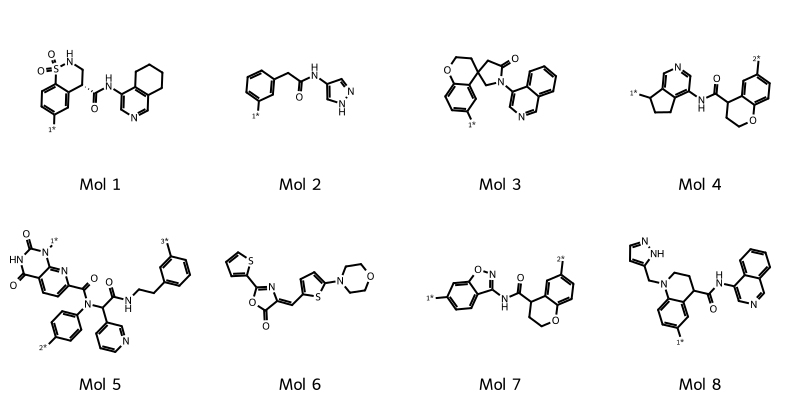

In [48]:
combinatorial_grid

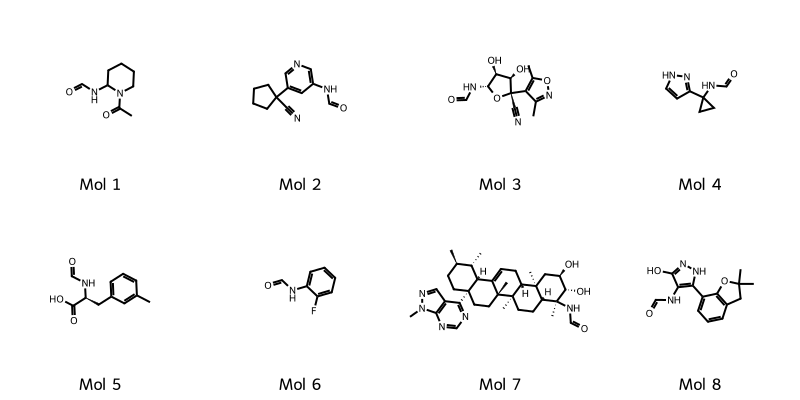

In [49]:
brics_grid

### <b> <font color='#A20025'> Cluster-based Compound Selection

Now that we have generated a large compound library, we need a way to select a diverse subset 
for screening. Clustering helps us group similar compounds together, then we can sample from each 
cluster to ensure diversity. We'll explore two clustering approaches:
 
1. Hierarchical clustering (agglomerative)
2. Prototype-based clustering (Taylor-Butina algorithm)


#### <b> <font color='#A20025'> Hierarchical Clustering: Agglomerative Clustering

Hierarchical clustering creates a hierarchy of clusters, with the option to "cut" the hierarchy at
different levels to obtain different numbers of clusters. We'll use Ward's method, which minimizes
the variance within each cluster.


In [50]:
def generate_fingerprints_for_clustering(molecules, radius=2, n_bits=2048):
    """
    Generate molecular fingerprints for clustering.
    
    Parameters:
    -----------
    molecules : list
        List of RDKit molecule objects
    radius : int
        Radius for fingerprints
    n_bits : int
        Number of bits in the fingerprint
        
    Returns:
    --------
    tuple
        Numpy array of fingerprints and list of RDKit fingerprints
    """
    # Use RDKit fingerprint generator for consistency
    rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
    
    # Generate fingerprints
    fingerprints = []
    rdkit_fps = []
    
    for mol in tqdm(molecules, desc="Generating fingerprints"):
        try:
            # Generate fingerprint
            fp = rdkit_gen.GetFingerprint(mol)
            rdkit_fps.append(fp)
            
            # Convert to numpy array
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints.append(arr)
        except Exception as e:
            print(f"Error generating fingerprint: {e}")
            # Add a placeholder to maintain indices
            fingerprints.append(np.zeros((1,)))
            rdkit_fps.append(None)
    
    # Combine into a single array
    fingerprints_array = np.array(fingerprints)
    
    print(f"Generated fingerprints with shape: {fingerprints_array.shape}")
    return fingerprints_array, rdkit_fps

# Generate fingerprints for the combined library
library_fps, library_rdkit_fps = generate_fingerprints_for_clustering(library_mols)

Generating fingerprints: 100%|██████████| 18085/18085 [00:37<00:00, 479.78it/s] 


Generated fingerprints with shape: (18085, 2048)


In [51]:
def perform_hierarchical_clustering(fingerprints, n_clusters=None, distance_threshold=None):
    """
    Perform hierarchical clustering on molecular fingerprints.
    
    Parameters:
    -----------
    fingerprints : numpy.ndarray
        Fingerprints for clustering
    n_clusters : int, optional
        Number of clusters to form
    distance_threshold : float, optional
        Maximum distance for clusters
        
    Returns:
    --------
    sklearn.cluster.AgglomerativeClustering
        Fitted clustering model
    """
    # Remove invalid fingerprints
    valid_indices = np.where(fingerprints.sum(axis=1) > 0)[0]
    valid_fps = fingerprints[valid_indices]
    
    print(f"Performing hierarchical clustering on {len(valid_fps)} valid fingerprints")
    
    # Create and fit clustering model
    if distance_threshold is not None:
        model = AgglomerativeClustering(
            distance_threshold=distance_threshold,
            n_clusters=None,
            linkage='ward'
        )
    else:
        model = AgglomerativeClustering(
            n_clusters=n_clusters if n_clusters else 10,
            linkage='ward'
        )
    
    model.fit(valid_fps)
    
    # Extract cluster information
    clusters = [
        np.where(model.labels_ == i)[0].tolist() 
        for i in range(max(model.labels_) + 1)
    ]
    
    # Map cluster indices back to original indices
    clusters = [
        [valid_indices[idx] for idx in cluster]
        for cluster in clusters
    ]
    
    print(f"Formed {len(clusters)} clusters")
    print(f"Cluster sizes: min={min(len(c) for c in clusters)}, max={max(len(c) for c in clusters)}")
    
    return model, clusters, valid_indices

# Perform initial hierarchical clustering without specifying n_clusters
# to visualize the hierarchy and determine a good number of clusters
exploratory_model, _, valid_indices = perform_hierarchical_clustering(
    library_fps, 
    distance_threshold=0,  # Cluster until all points are merged
    n_clusters=None
)

Performing hierarchical clustering on 18085 valid fingerprints
Formed 18085 clusters
Cluster sizes: min=1, max=1


Figure saved as figures/ch07/dendrogram_p3.png
Figure saved as figures/ch07/dendrogram_p3.pdf
Figure saved as figures/ch07/dendrogram_p7.png
Figure saved as figures/ch07/dendrogram_p7.pdf


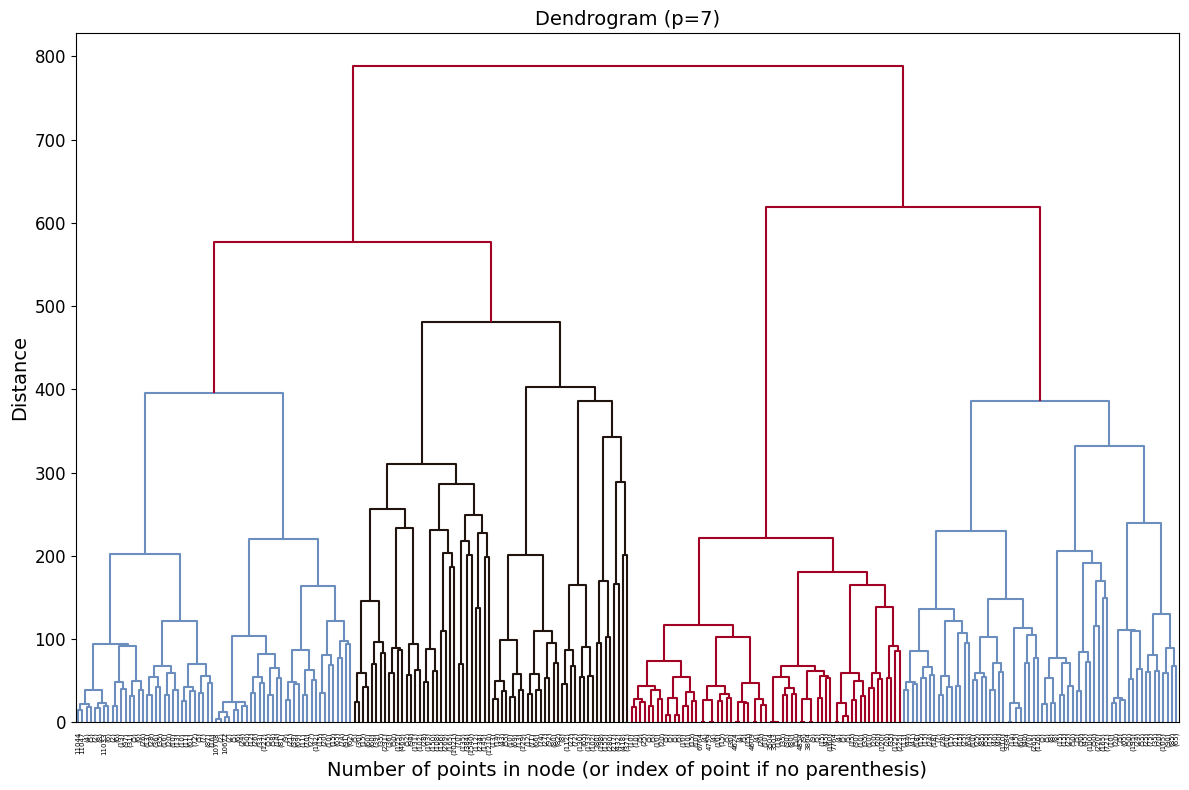

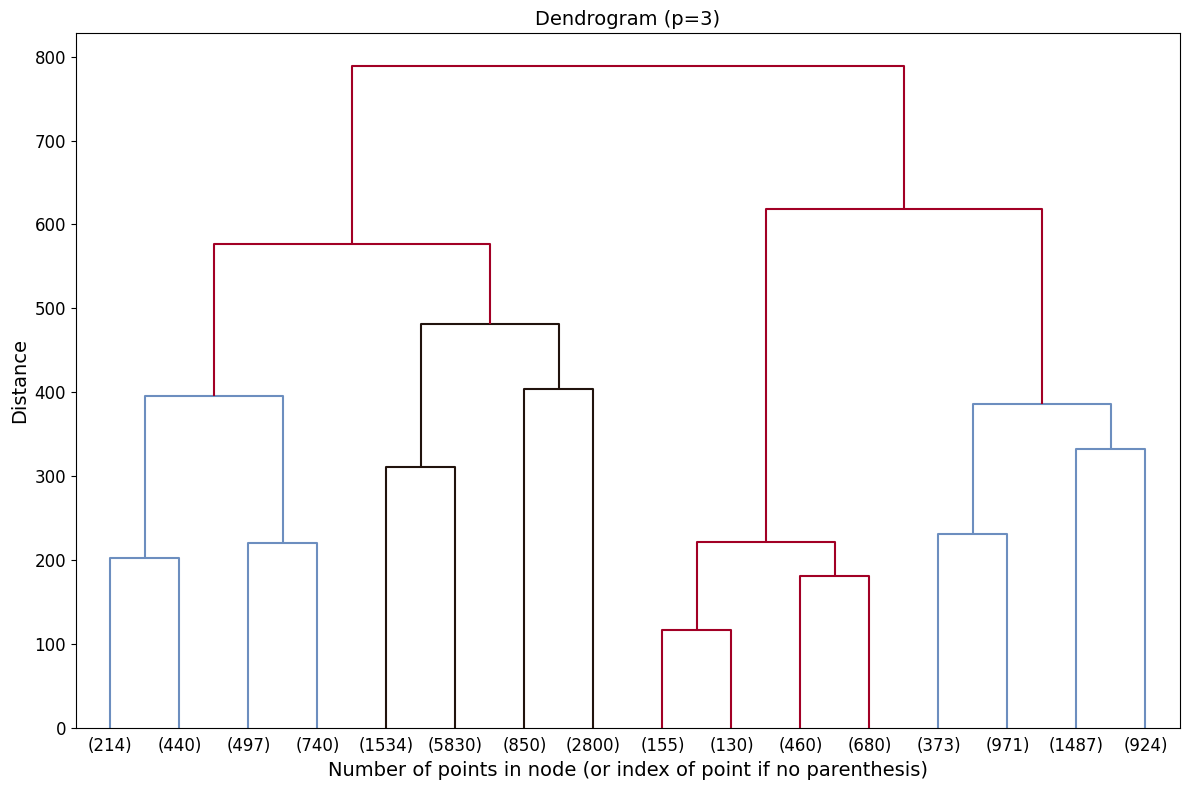

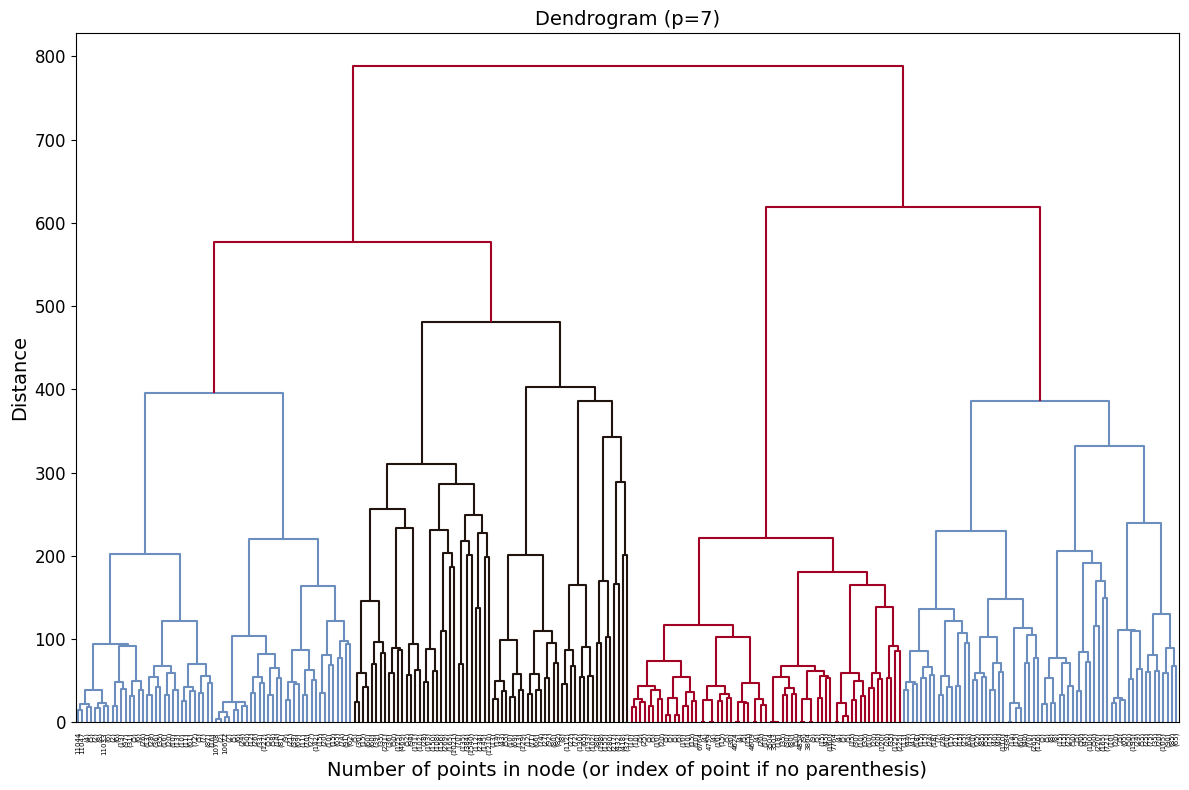

In [52]:
def create_dendrogram(linkage_matrix, truncate_mode=None, p=None, title="Hierarchical Clustering Dendrogram"):
    """
    Create a dendrogram visualization from a linkage matrix.
    
    Parameters:
    -----------
    linkage_matrix : numpy.ndarray
        Linkage matrix from hierarchical clustering
    truncate_mode : str, optional
        How to truncate the dendrogram
    p : int, optional
        Parameter for truncation
    title : str
        Title for the dendrogram
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure with the dendrogram
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot dendrogram
    dendrogram(
        linkage_matrix,
        truncate_mode=truncate_mode,
        p=p,
        show_leaf_counts=True,
        ax=ax
    )
    
    # Set title and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Number of points in node (or index of point if no parenthesis)")
    ax.set_ylabel("Distance")
    
    fig.tight_layout()
    
    # Save figure with truncation info in filename
    suffix = f"_p{p}" if p else ""
    save_figure(fig, f"dendrogram{suffix}")
    
    return fig

def plot_dendrogram_from_model(model, p=3, title="Hierarchical Clustering Dendrogram"):
    """
    Create a dendrogram visualization from a AgglomerativeClustering model.
    
    Parameters:
    -----------
    model : sklearn.cluster.AgglomerativeClustering
        Fitted clustering model
    p : int, optional
        Parameter for truncation
    title : str
        Title for the dendrogram
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure with the dendrogram
    """
    # Create linkage matrix from the model
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([
        model.children_, 
        model.distances_,
        counts
    ]).astype(float)
    
    # Create dendrogram
    return create_dendrogram(
        linkage_matrix,
        truncate_mode='level',
        p=p,
        title=title
    )

# Create dendrograms at different levels of detail
plot_dendrogram_from_model(exploratory_model, p=3, title="Dendrogram (p=3)")
plot_dendrogram_from_model(exploratory_model, p=7, title="Dendrogram (p=7)")

In [53]:
# Based on the dendrogram, choose a reasonable number of clusters
n_clusters = 16
agg_model, agg_clusters, _ = perform_hierarchical_clustering(library_fps, n_clusters=n_clusters)

Performing hierarchical clustering on 18085 valid fingerprints
Formed 16 clusters
Cluster sizes: min=475, max=2129


Figure saved as figures/ch07/hierarchical_cluster_sizes.png
Figure saved as figures/ch07/hierarchical_cluster_sizes.pdf


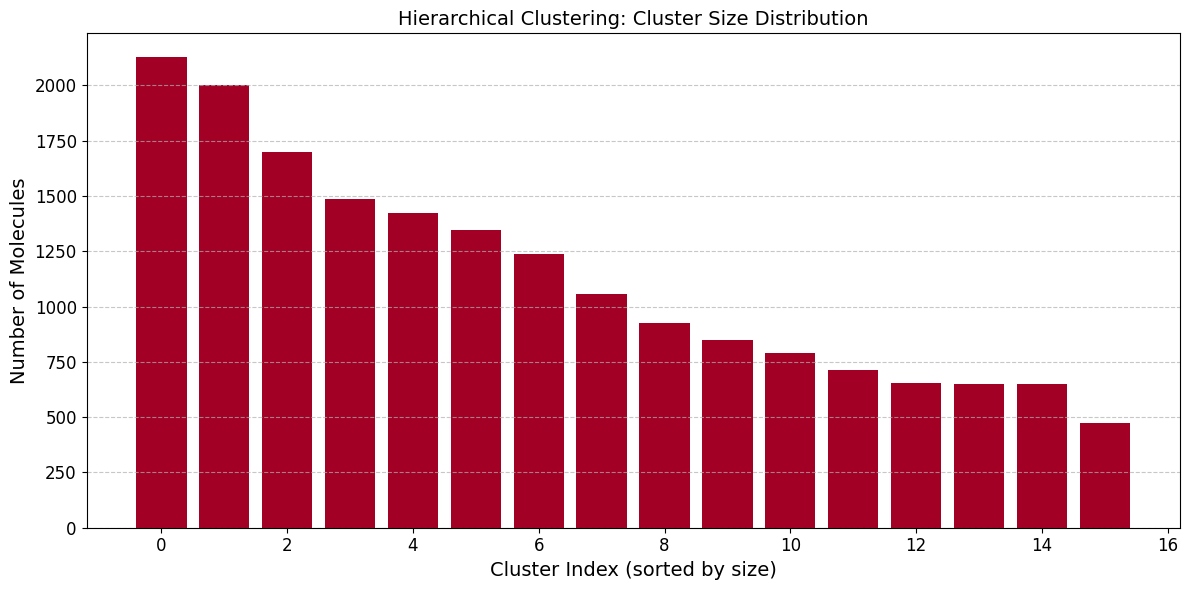

In [54]:
def visualize_cluster_sizes(clusters, title="Cluster Size Distribution"):
    """
    Visualize the distribution of cluster sizes.
    
    Parameters:
    -----------
    clusters : list
        List of clusters, where each cluster is a list of indices
    title : str
        Title for the plot
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure with the visualization
    """
    # Sort clusters by size
    cluster_sizes = [len(cluster) for cluster in clusters]
    sorted_indices = np.argsort(cluster_sizes)[::-1]
    sorted_sizes = [cluster_sizes[i] for i in sorted_indices]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create bar plot
    ax.bar(range(len(sorted_sizes)), sorted_sizes)
    
    # Set title and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Cluster Index (sorted by size)")
    ax.set_ylabel("Number of Molecules")
    
    # Add grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    fig.tight_layout()
    
    return fig

# Visualize cluster size distribution
agg_cluster_sizes_fig = visualize_cluster_sizes(agg_clusters, title="Hierarchical Clustering: Cluster Size Distribution")
save_figure(agg_cluster_sizes_fig, "hierarchical_cluster_sizes")


In [55]:
def sample_diverse_compounds(fingerprints, clusters, n_per_cluster=3):
    """
    Sample diverse compounds from clusters by selecting compounds nearest to cluster centroids.
    
    Parameters:
    -----------
    fingerprints : numpy.ndarray
        Fingerprints for all compounds
    clusters : list
        List of clusters, where each cluster is a list of indices
    n_per_cluster : int
        Number of compounds to sample from each cluster
        
    Returns:
    --------
    list
        Indices of sampled compounds
    """
    sampled_indices = []
    
    for cluster in tqdm(clusters, desc="Sampling from clusters"):
        if len(cluster) == 0:
            continue
            
        # If cluster is smaller than n_per_cluster, take all compounds
        if len(cluster) <= n_per_cluster:
            sampled_indices.extend(cluster)
            continue
        
        # Extract fingerprints for this cluster
        cluster_fps = fingerprints[cluster]
        
        # Calculate cluster centroid
        centroid = np.mean(cluster_fps, axis=0).reshape(1, -1)
        
        # Calculate distances to centroid
        distances = cdist(cluster_fps, centroid, metric='euclidean').flatten()
        
        # Get indices of n_per_cluster compounds closest to centroid
        closest_local_indices = np.argsort(distances)[:n_per_cluster]
        
        # Map back to original indices
        closest_global_indices = [cluster[idx] for idx in closest_local_indices]
        sampled_indices.extend(closest_global_indices)
    
    print(f"Sampled {len(sampled_indices)} compounds from {len(clusters)} clusters")
    return sampled_indices

# Sample diverse compounds from each cluster
agg_sampled_indices = sample_diverse_compounds(library_fps, agg_clusters, n_per_cluster=3)
agg_sampled_molecules = [library_mols[i] for i in agg_sampled_indices]


Sampling from clusters: 100%|██████████| 16/16 [00:01<00:00, 10.33it/s]

Sampled 48 compounds from 16 clusters


#### <b> <font color='#A20025'> Prototype-based Clustering: Taylor-Butina Clustering

Taylor-Butina clustering is a non-hierarchical clustering method that groups compounds based on a similarity threshold.
It's particularly well-suited for chemical libraries because it naturally handles the asymmetric nature of chemical similarity.


**😱 Long Running Code Block**

The following code block may take a long time to run (15 minutes). If you want to save time, you can just cluster using the optimal cutoff of 0.2 to lower the runtime to approximately 5 minutes.


Evaluating cutoff: 0.2
Performing Taylor-Butina clustering on 18085 fingerprints with cutoff 0.2


Calculating distances: 100%|██████████| 18084/18084 [02:36<00:00, 115.53it/s]


Formed 4709 clusters
Cluster sizes: min=1, max=440
Number of clusters: 4709
calinski_harabasz: 33.15617242150323
silhouette: 0.33150969087905946
davies_bouldin: 0.6666528142192406

Evaluating cutoff: 0.4
Performing Taylor-Butina clustering on 18085 fingerprints with cutoff 0.4


Calculating distances: 100%|██████████| 18084/18084 [03:09<00:00, 95.30it/s] 


Formed 1582 clusters
Cluster sizes: min=1, max=1159
Number of clusters: 1582
calinski_harabasz: 28.060928043246758
silhouette: 0.17525813695176712
davies_bouldin: 1.0853400356452918

Evaluating cutoff: 0.6
Performing Taylor-Butina clustering on 18085 fingerprints with cutoff 0.6


Calculating distances: 100%|██████████| 18084/18084 [02:50<00:00, 106.20it/s]


Formed 417 clusters
Cluster sizes: min=1, max=4605
Number of clusters: 417
calinski_harabasz: 33.72301403806398
silhouette: 0.029626950615192455
davies_bouldin: 1.59484531811954
Figure saved as figures/ch07/butina_cutoff_optimization.png
Figure saved as figures/ch07/butina_cutoff_optimization.pdf

Optimal cutoff based on silhouette score: 0.2


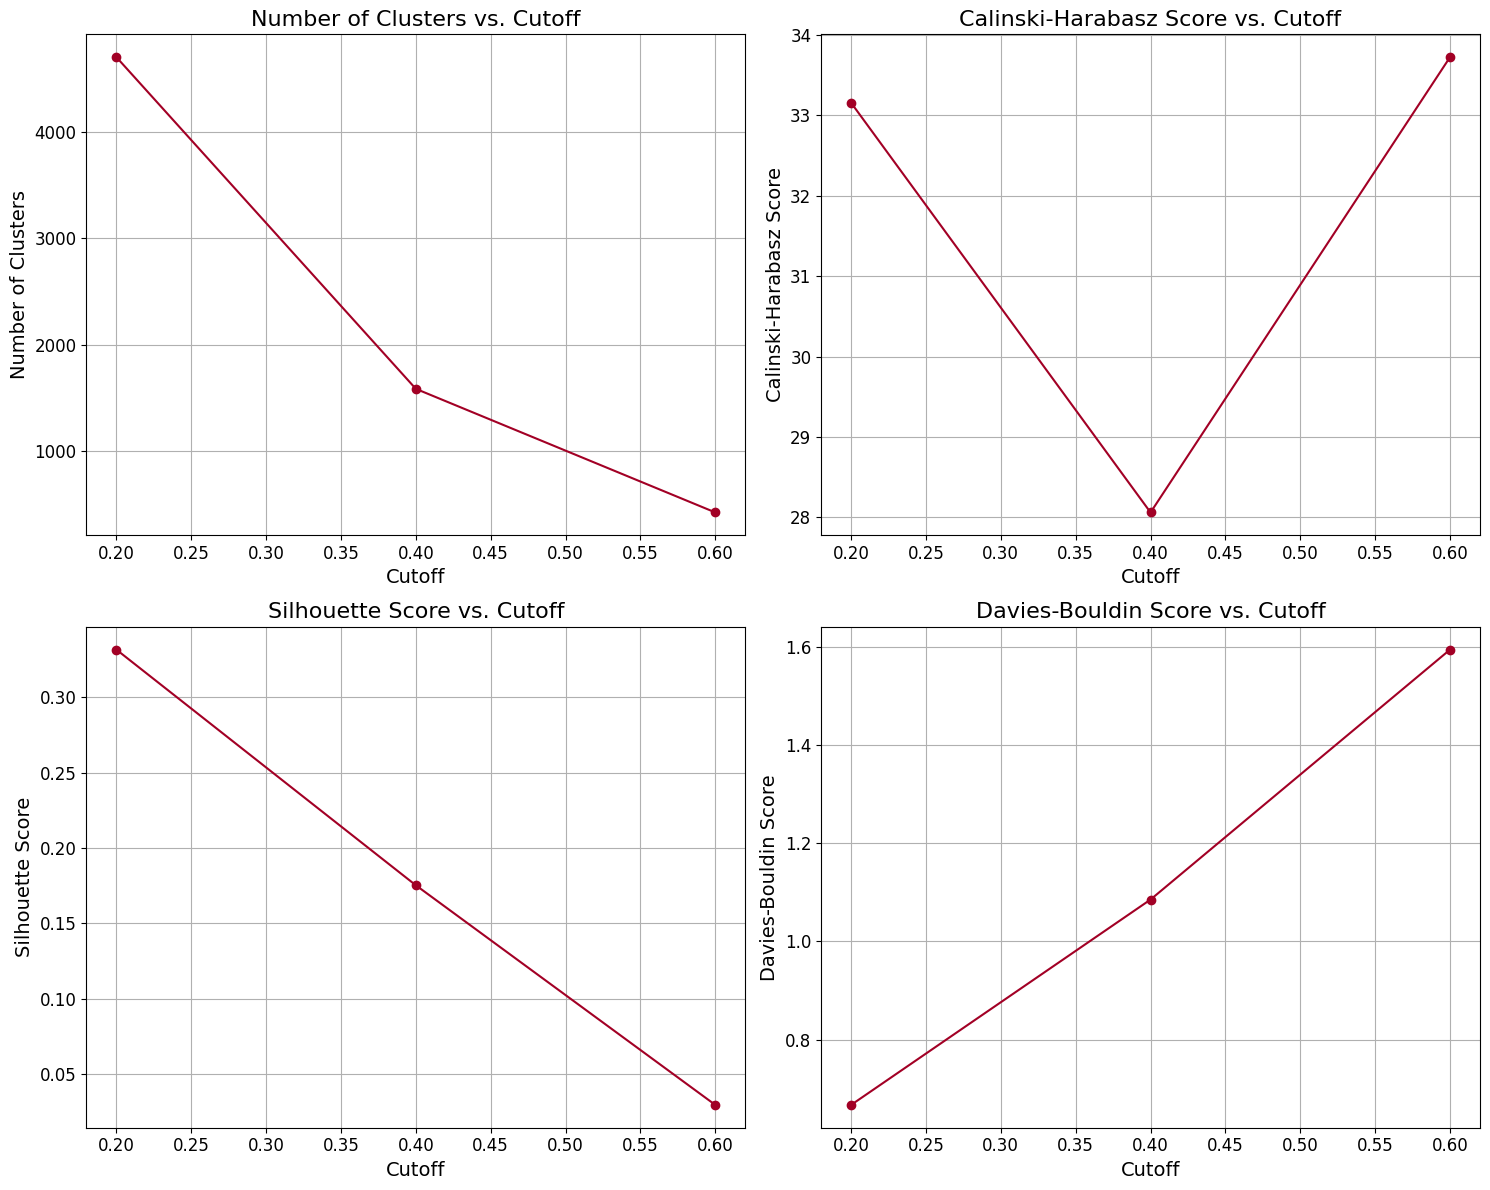

In [56]:
def butina_clustering(fingerprints, cutoff=0.2):
    """
    Perform Taylor-Butina clustering on molecular fingerprints.
    
    Parameters:
    -----------
    fingerprints : list
        List of RDKit fingerprints
    cutoff : float
        Similarity cutoff (1 - Tanimoto coefficient)
        
    Returns:
    --------
    list
        List of clusters, where each cluster is a list of indices
    """
    # Remove None values
    valid_indices = [i for i, fp in enumerate(fingerprints) if fp is not None]
    valid_fps = [fingerprints[i] for i in valid_indices]
    
    if not valid_fps:
        print("No valid fingerprints for clustering")
        return []
    
    print(f"Performing Taylor-Butina clustering on {len(valid_fps)} fingerprints with cutoff {cutoff}")
    
    # Calculate all pairwise distances
    dists = []
    nfps = len(valid_fps)
    
    for i in tqdm(range(1, nfps), desc="Calculating distances"):
        sims = DataStructs.BulkTanimotoSimilarity(valid_fps[i], valid_fps[:i])
        dists.extend([1 - x for x in sims])
    
    # Perform clustering
    cluster_data = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    
    # Map cluster indices back to original indices
    clusters = [[valid_indices[idx] for idx in cluster] for cluster in cluster_data]
    
    print(f"Formed {len(clusters)} clusters")
    if clusters:
        print(f"Cluster sizes: min={min(len(c) for c in clusters)}, max={max(len(c) for c in clusters)}")
    
    return clusters

def evaluate_clustering(fingerprints, cluster_labels):
    """
    Evaluate clustering using internal validation metrics.
    
    Parameters:
    -----------
    fingerprints : numpy.ndarray
        Fingerprints used for clustering
    cluster_labels : numpy.ndarray
        Cluster labels for each fingerprint
        
    Returns:
    --------
    dict
        Dictionary of evaluation metrics
    """
    try:
        # Calculate Calinski-Harabasz score (higher is better)
        ch_score = calinski_harabasz_score(fingerprints, cluster_labels)
        
        # Calculate silhouette score (higher is better)
        silhouette = silhouette_score(fingerprints, cluster_labels)
        
        # Calculate Davies-Bouldin score (lower is better)
        db_score = davies_bouldin_score(fingerprints, cluster_labels)
        
        return {
            "calinski_harabasz": ch_score,
            "silhouette": silhouette,
            "davies_bouldin": db_score
        }
    
    except Exception as e:
        print(f"Error calculating clustering metrics: {e}")
        return {
            "calinski_harabasz": None,
            "silhouette": None,
            "davies_bouldin": None
        }

def optimize_butina_cutoff(rdkit_fps, fingerprints, cutoffs=None):
    """
    Optimize the cutoff parameter for Taylor-Butina clustering.
    
    Parameters:
    -----------
    rdkit_fps : list
        List of RDKit fingerprints
    fingerprints : numpy.ndarray
        Numpy array of fingerprints
    cutoffs : list, optional
        List of cutoff values to evaluate
        
    Returns:
    --------
    float
        Optimal cutoff value
    """
    if cutoffs is None:
        cutoffs = np.arange(0.1, 0.7, 0.1)
    
    results = []
    clusters_by_cutoff = {}
    
    for cutoff in cutoffs:
        print(f"\nEvaluating cutoff: {cutoff}")
        
        # Perform clustering
        clusters = butina_clustering(rdkit_fps, cutoff)
        clusters_by_cutoff[cutoff] = clusters
        
        # Prepare cluster labels for evaluation
        cluster_labels = np.zeros(len(fingerprints))
        for cluster_id, cluster in enumerate(clusters):
            for idx in cluster:
                cluster_labels[idx] = cluster_id
        
        # Evaluate clustering
        metrics = evaluate_clustering(fingerprints, cluster_labels)
        
        results.append({
            "cutoff": cutoff,
            "n_clusters": len(clusters),
            **metrics
        })
        
        print(f"Number of clusters: {len(clusters)}")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")
    
    # Convert results to dataframe
    results_df = pd.DataFrame(results)
    
    # Plot evaluation metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Number of clusters
    axes[0, 0].plot(results_df["cutoff"], results_df["n_clusters"], marker='o')
    axes[0, 0].set_xlabel("Cutoff")
    axes[0, 0].set_ylabel("Number of Clusters")
    axes[0, 0].set_title("Number of Clusters vs. Cutoff")
    axes[0, 0].grid(True)
    
    # Calinski-Harabasz score
    axes[0, 1].plot(results_df["cutoff"], results_df["calinski_harabasz"], marker='o')
    axes[0, 1].set_xlabel("Cutoff")
    axes[0, 1].set_ylabel("Calinski-Harabasz Score")
    axes[0, 1].set_title("Calinski-Harabasz Score vs. Cutoff")
    axes[0, 1].grid(True)
    
    # Silhouette score
    axes[1, 0].plot(results_df["cutoff"], results_df["silhouette"], marker='o')
    axes[1, 0].set_xlabel("Cutoff")
    axes[1, 0].set_ylabel("Silhouette Score")
    axes[1, 0].set_title("Silhouette Score vs. Cutoff")
    axes[1, 0].grid(True)
    
    # Davies-Bouldin score
    axes[1, 1].plot(results_df["cutoff"], results_df["davies_bouldin"], marker='o')
    axes[1, 1].set_xlabel("Cutoff")
    axes[1, 1].set_ylabel("Davies-Bouldin Score")
    axes[1, 1].set_title("Davies-Bouldin Score vs. Cutoff")
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    save_figure(fig, "butina_cutoff_optimization")
    
    # Determine optimal cutoff (could use different criteria)
    optimal_cutoff = results_df.loc[results_df["silhouette"].idxmax(), "cutoff"]
    print(f"\nOptimal cutoff based on silhouette score: {optimal_cutoff}")
    
    return optimal_cutoff, clusters_by_cutoff, results_df

# Optimize Taylor-Butina cutoff
# Using a smaller range of cutoffs for demonstration
cutoffs = [0.2, 0.4, 0.6]
optimal_cutoff, clusters_by_cutoff, butina_results = optimize_butina_cutoff(
    library_rdkit_fps, 
    library_fps,
    cutoffs
)

# Select clusters for the optimal cutoff
butina_clusters = clusters_by_cutoff[optimal_cutoff]

We evaluate the distribution, as too many singletons (threshold of 0.0, see figure 7.11 in the text) or all molecules in one cluster (occurs with threshold of 0.8, see figure 7.11 in the text) are not ideal.

Figure saved as figures/ch07/butina_cluster_sizes.png
Figure saved as figures/ch07/butina_cluster_sizes.pdf


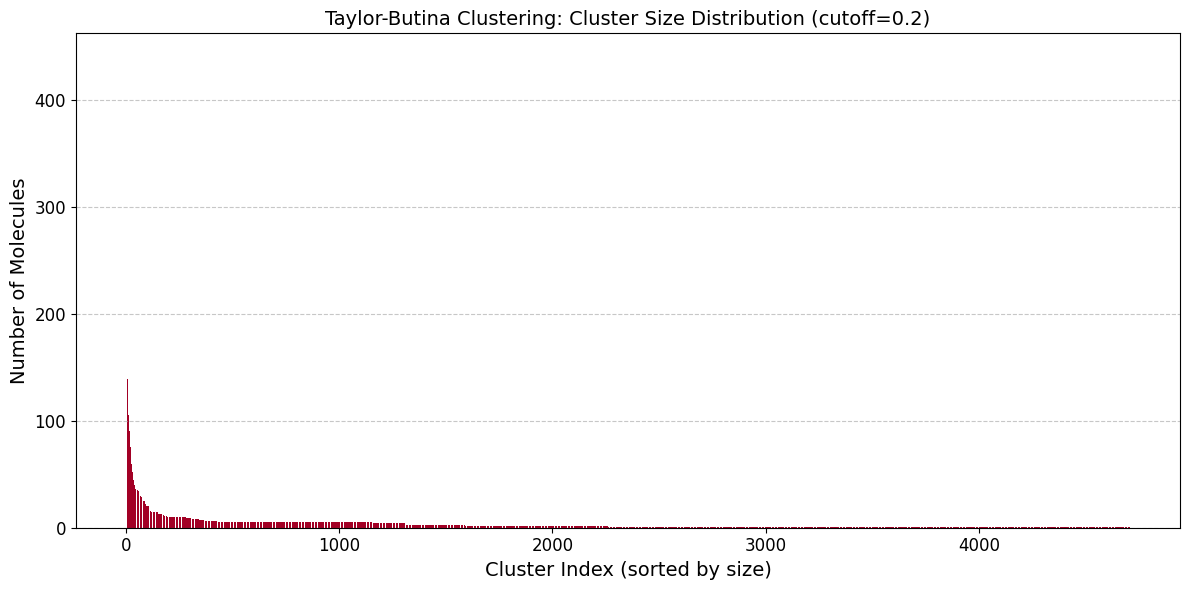

In [57]:
# Visualize cluster size distribution
butina_cluster_sizes_fig = visualize_cluster_sizes(
    butina_clusters, 
    title=f"Taylor-Butina Clustering: Cluster Size Distribution (cutoff={optimal_cutoff})"
)
save_figure(butina_cluster_sizes_fig, "butina_cluster_sizes")

In [58]:
# Sample diverse compounds from each cluster
butina_sampled_indices = sample_diverse_compounds(library_fps, butina_clusters, n_per_cluster=3)
butina_sampled_molecules = [library_mols[i] for i in butina_sampled_indices]

Sampling from clusters: 100%|██████████| 4709/4709 [00:00<00:00, 12390.95it/s]

Sampled 8560 compounds from 4709 clusters


### <b> <font color='#A20025'> Comparing Clustering Methods

Let's compare the hierarchical clustering and Taylor-Butina clustering approaches to see which 
produces a more diverse selection of compounds.

From the following results, both methods were comparable. But Taylor-Butina approach had slightly more diversity and less redundancy while sampling a much larger yield (~8K molecules vs 48 for hierarchical approach). Do you think that increasing the number of compounds sampled per cluster for the hierarchical approach would improve or further worsen its diversity and redundancy relative to the Taylor-Butina approach?

**😱 Long Running Code Block**

The following code block may take a long time to run (12 minutes). If you want to save time, you can skip this cell. Both methods result in a diversity of around 0.8 Tanimoto distance (1 - similarity) and close to 0 for the redundancy measure.

Figure saved as figures/ch07/clustering_methods_comparison.png
Figure saved as figures/ch07/clustering_methods_comparison.pdf

Clustering Methods Comparison:
          Method  Sample Size  Diversity (Avg Distance)  Redundancy Ratio
0   Hierarchical           48                  0.810147          0.008865
1  Taylor-Butina         8560                  0.833244          0.000012


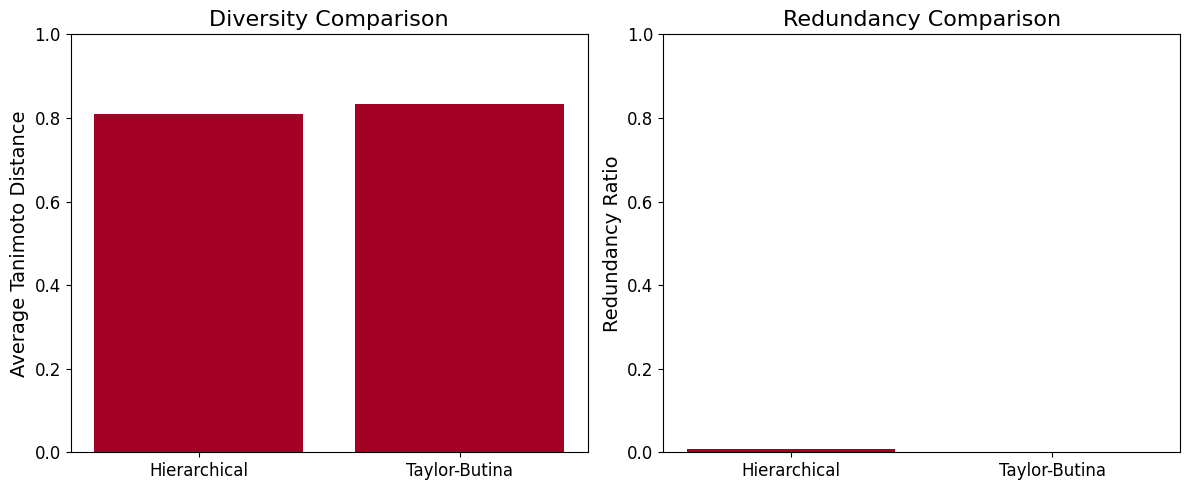

In [59]:
def calculate_tanimoto_distances(fingerprints):
    """
    Calculate pairwise Tanimoto distances between fingerprints.
    
    Parameters:
    -----------
    fingerprints : list
        List of RDKit fingerprints
        
    Returns:
    --------
    numpy.ndarray
        Matrix of Tanimoto distances
    """
    n = len(fingerprints)
    tanimoto_distances = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            if fingerprints[i] is not None and fingerprints[j] is not None:
                similarity = DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
                distance = 1 - similarity
                tanimoto_distances[i, j] = distance
                tanimoto_distances[j, i] = distance
    
    return tanimoto_distances

def calculate_diversity(sampled_indices, fingerprints):
    """
    Calculate the diversity of a set of molecules based on average Tanimoto distance.
    
    Parameters:
    -----------
    sampled_indices : list
        Indices of sampled molecules
    fingerprints : list
        List of RDKit fingerprints for all molecules
        
    Returns:
    --------
    float
        Average Tanimoto distance (higher means more diverse)
    """
    sampled_fps = [fingerprints[i] for i in sampled_indices if fingerprints[i] is not None]
    
    if len(sampled_fps) < 2:
        return 0
    
    tanimoto_distances = calculate_tanimoto_distances(sampled_fps)
    
    # Calculate average distance (excluding self-comparisons)
    n = len(sampled_fps)
    total_distance = tanimoto_distances.sum() - np.trace(tanimoto_distances)
    avg_distance = total_distance / (n * (n - 1))
    
    return avg_distance

def calculate_redundancy(sampled_indices, fingerprints, threshold=0.85):
    """
    Calculate the redundancy of a set of molecules based on the proportion
    of highly similar pairs.
    
    Parameters:
    -----------
    sampled_indices : list
        Indices of sampled molecules
    fingerprints : list
        List of RDKit fingerprints for all molecules
    threshold : float
        Similarity threshold for determining redundancy
        
    Returns:
    --------
    float
        Redundancy ratio (lower means less redundant)
    """
    sampled_fps = [fingerprints[i] for i in sampled_indices if fingerprints[i] is not None]
    
    if len(sampled_fps) < 2:
        return 0
    
    # Calculate similarity matrix
    n = len(sampled_fps)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            if sampled_fps[i] is not None and sampled_fps[j] is not None:
                similarity = DataStructs.FingerprintSimilarity(sampled_fps[i], sampled_fps[j])
                similarity_matrix[i, j] = similarity
                similarity_matrix[j, i] = similarity
    
    # Count redundant pairs (highly similar molecules)
    redundant_pairs = (similarity_matrix > threshold).sum() - n  # Exclude self-comparisons
    total_pairs = n * (n - 1)
    
    redundancy_ratio = redundant_pairs / total_pairs
    
    return redundancy_ratio

def compare_clustering_methods(methods, sampled_indices_dict, fingerprints):
    """
    Compare different clustering methods based on diversity and redundancy.
    
    Parameters:
    -----------
    methods : list
        List of method names
    sampled_indices_dict : dict
        Dictionary mapping method names to lists of sampled indices
    fingerprints : list
        List of RDKit fingerprints for all molecules
        
    Returns:
    --------
    pandas.DataFrame
        Comparison results
    """
    results = []
    
    for method in methods:
        sampled_indices = sampled_indices_dict[method]
        diversity = calculate_diversity(sampled_indices, fingerprints)
        redundancy = calculate_redundancy(sampled_indices, fingerprints)
        
        results.append({
            "Method": method,
            "Sample Size": len(sampled_indices),
            "Diversity (Avg Distance)": diversity,
            "Redundancy Ratio": redundancy
        })
    
    results_df = pd.DataFrame(results)
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Diversity comparison
    ax1.bar(results_df["Method"], results_df["Diversity (Avg Distance)"])
    ax1.set_title("Diversity Comparison")
    ax1.set_ylabel("Average Tanimoto Distance")
    ax1.set_ylim(0, 1)
    
    # Redundancy comparison
    ax2.bar(results_df["Method"], results_df["Redundancy Ratio"])
    ax2.set_title("Redundancy Comparison")
    ax2.set_ylabel("Redundancy Ratio")
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    save_figure(fig, "clustering_methods_comparison")
    
    return results_df

# Compare the clustering methods
methods = ["Hierarchical", "Taylor-Butina"]
sampled_indices_dict = {
    "Hierarchical": agg_sampled_indices,
    "Taylor-Butina": butina_sampled_indices
}

comparison_results = compare_clustering_methods(
    methods, 
    sampled_indices_dict, 
    library_rdkit_fps
)

print("\nClustering Methods Comparison:")
print(comparison_results)

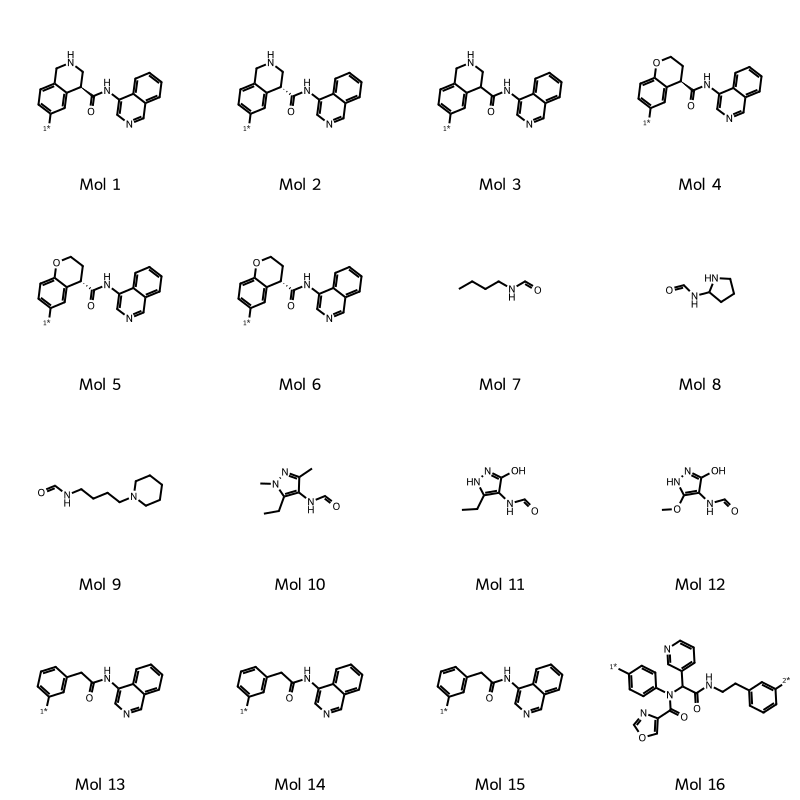

In [86]:
# Visualize sampled molecules from each method
hierarchical_grid = visualize_molecule_grid(
    [library_mols[i] for i in agg_sampled_indices[:16]], 
    title="Hierarchical Clustering: Sampled Molecules"
)

hierarchical_grid

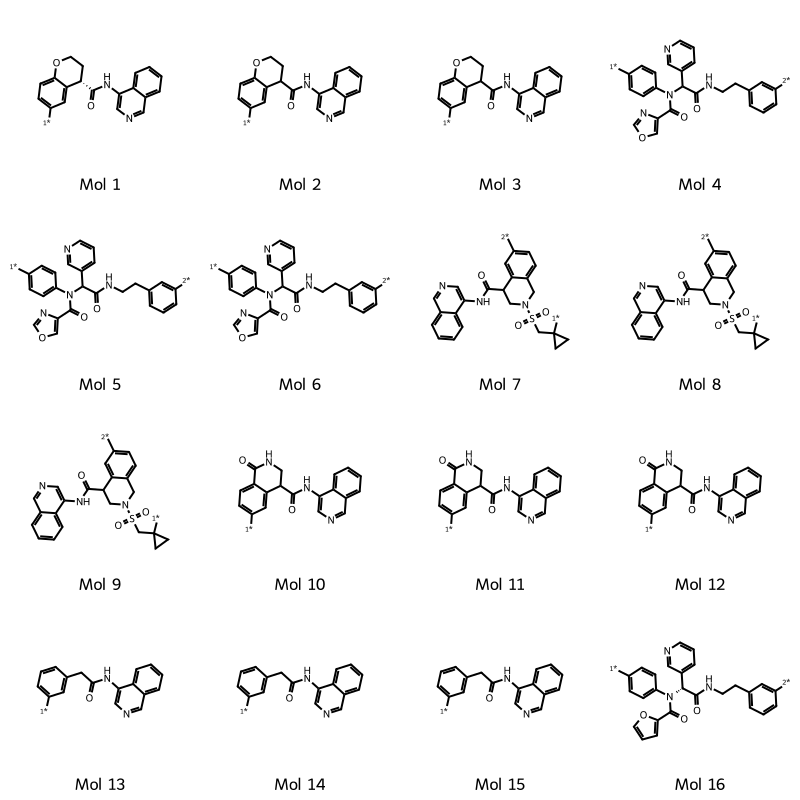

In [87]:
butina_grid = visualize_molecule_grid(
    [library_mols[i] for i in butina_sampled_indices[:16]], 
    title="Taylor-Butina Clustering: Sampled Molecules"
)
butina_grid

## <b> <font color='#A20025'> 3️⃣ Density Estimation: Fragment-based Drug Discovery

This section explores density estimation techniques for fragment-based drug discovery,
focusing on pharmacophore modeling and fragment library design.


### <b> <font color='#A20025'> Introduction to Density Estimation

Density estimation is the process of estimating the probability density function of a random variable
based on observed data. In drug discovery, it can be used to model the distribution of important features
like pharmacophore distances, which help in understanding how fragments interact with target proteins.

Figure saved as figures/ch07/kde_example.png
Figure saved as figures/ch07/kde_example.pdf


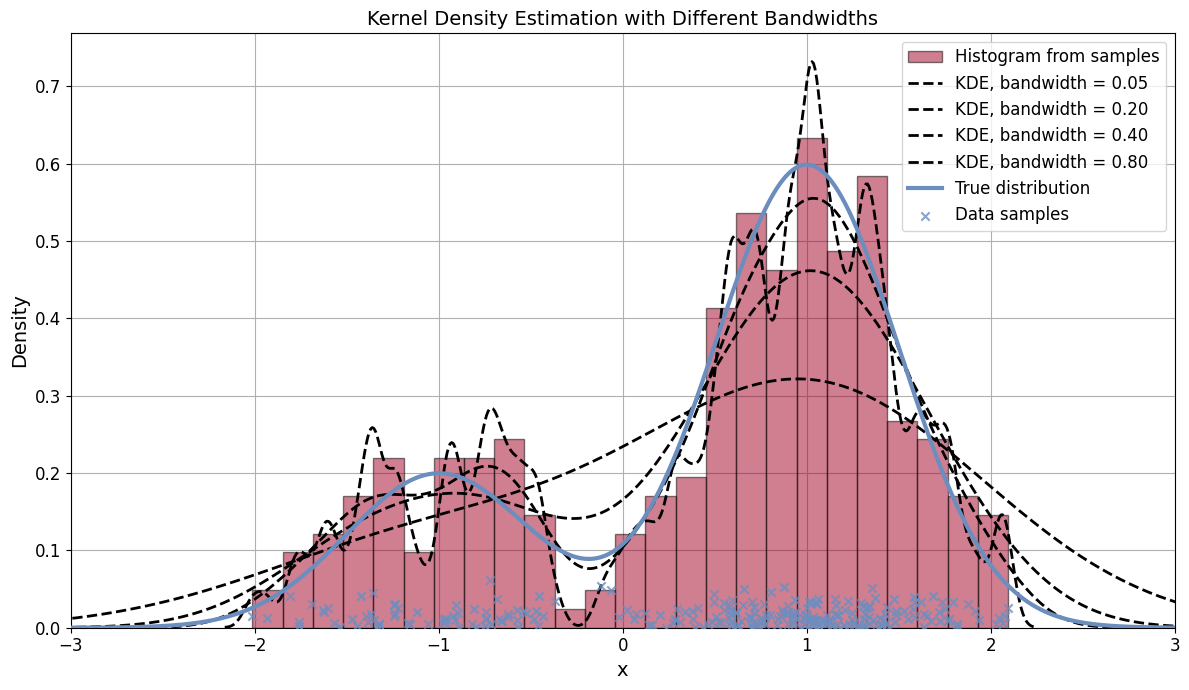

In [60]:
def demonstrate_density_estimation(n_samples=250):
    """
    Demonstrate kernel density estimation on a bimodal distribution.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure with the density estimation visualization
    """
    # Define parameters for a mixture of two normal distributions
    dist1_loc, dist1_scale, weight1 = -1, 0.5, 0.25  # First distribution
    dist2_loc, dist2_scale, weight2 = 1, 0.5, 0.75   # Second distribution
    
    # Generate random samples from the mixture
    np.random.seed(RANDOM_SEED)
    obs_dist = mixture_rvs(
        prob=[weight1, weight2],
        size=n_samples,
        dist=[stats.norm, stats.norm],
        kwargs=(
            dict(loc=dist1_loc, scale=dist1_scale),
            dict(loc=dist2_loc, scale=dist2_scale),
        )
    )
    
    # Fit KDE with different bandwidths
    kde = sm.nonparametric.KDEUnivariate(obs_dist)
    
    # Create visualization
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111)
    
    # Plot the histogram
    ax.hist(
        obs_dist,
        bins=25,
        label="Histogram from samples",
        zorder=5,
        edgecolor="k",
        density=True,
        alpha=0.5,
    )
    
    # Plot the KDE for various bandwidths
    bandwidths = [0.05, 0.2, 0.4, 0.8]
    for bandwidth in bandwidths:
        kde.fit(bw=bandwidth)
        ax.plot(
            kde.support,
            kde.density,
            "--",
            lw=2,
            color="k",
            zorder=10,
            label=f"KDE, bandwidth = {bandwidth:.2f}",
        )
    
    # Plot the true distribution
    x = np.linspace(-3, 3, 1000)
    true_values = (
        stats.norm.pdf(x, loc=dist1_loc, scale=dist1_scale) * weight1 +
        stats.norm.pdf(x, loc=dist2_loc, scale=dist2_scale) * weight2
    )
    ax.plot(x, true_values, lw=3, label="True distribution", zorder=15)
    
    # Plot the samples
    ax.scatter(
        obs_dist,
        np.abs(np.random.randn(obs_dist.size)) / 50,
        marker="x",
        color="#6C8EBF",
        zorder=20,
        label="Data samples",
        alpha=0.8,
    )
    
    # Add title and labels
    ax.set_title("Kernel Density Estimation with Different Bandwidths", fontsize=14)
    ax.set_xlabel("x")
    ax.set_ylabel("Density")
    ax.set_xlim([-3, 3])
    ax.grid(True, zorder=-5)
    
    # Add legend
    ax.legend(loc="best")
    
    fig.tight_layout()
    save_figure(fig, "kde_example")
    
    return fig

# Demonstrate density estimation
kde_fig = demonstrate_density_estimation()

### <b> <font color='#A20025'> FRESCO: Fragment Screening through Computational Analysis

FRESCO (Fragment Screening through Computational Analysis) is an approach that uses density estimation 
to evaluate fragments based on their pharmacophore features. Here, we'll implement a simplified version
of the FRESCO pipeline to demonstrate how it works.
 
The main steps are:
1. Extract pharmacophore features from fragment structures
2. Calculate pairwise distances between pharmacophores
3. Fit kernel density estimations to model the distribution of these distances
4. Score new molecules based on how well they match these distributions

In [61]:
def load_fragment_data(sdf_file):
    """
    Load fragment data from an SDF file.
    
    Parameters:
    -----------
    sdf_file : str
        Path to the SDF file
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing fragment data
    """
    try:
        print(f"Loading fragment data from {sdf_file}...")
        df_fragments = PandasTools.LoadSDF(
            sdf_file, 
            idName='name', 
            smilesName='SMILES', 
            molColName='mol'
        )
        
        print(f"Loaded {len(df_fragments)} fragments")
        return df_fragments
    
    except Exception as e:
        print(f"Error loading fragment data: {str(e)}")
        raise

# Load fragment data
df_fragments = load_fragment_data('data/ch07/raw/mpro_frags.sdf')

Loading fragment data from data/ch07/raw/mpro_frags.sdf...
Loaded 23 fragments


In [64]:
def compute_pharmacophore_data(mol, mol_id=0):
    """
    Extract pharmacophore features from a molecule.
    
    Parameters:
    -----------
    mol : rdkit.Chem.rdchem.Mol
        RDKit molecule object
    mol_id : int
        Identifier for the molecule
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing pharmacophore information
    """
    # Define pharmacophore types of interest
    pcores_of_interest = ['Donor', 'Acceptor', 'Aromatic']
    
    # Load feature definition file
    fdef_file = os.path.join(RDDataDir, 'BaseFeatures.fdef')
    feat_factory = ChemicalFeatures.BuildFeatureFactory(fdef_file)
    
    try:
        # Get 3D coordinates and pharmacophore features
        if mol.GetNumConformers() == 0:
            return pd.DataFrame()  # Skip molecules without 3D coordinates
            
        atom_coordinates = mol.GetConformer().GetPositions()
        pharmacophore_features = feat_factory.GetFeaturesForMol(mol)
        
        # Collect pharmacophore data
        rows = []
        for pcore in pharmacophore_features:
            pcore_name = pcore.GetFamily()
            
            if pcore_name in pcores_of_interest:
                atom_ids = pcore.GetAtomIds()
                xyz = np.mean([atom_coordinates[id] for id in atom_ids], axis=0)
                
                rows.append({
                    'pcore': pcore_name,
                    'smiles': MolToSmiles(mol),
                    'mol_id': mol_id,
                    'coord_x': xyz[0],
                    'coord_y': xyz[1],
                    'coord_z': xyz[2],
                })
        
        return pd.DataFrame(rows)
    
    except Exception as e:
        print(f"Error computing pharmacophore data for molecule {mol_id}: {str(e)}")
        return pd.DataFrame()

def extract_pharmacophores_from_fragments(df_fragments):
    """
    Extract pharmacophore features from all fragments in a dataset.
    
    Parameters:
    -----------
    df_fragments : pandas.DataFrame
        DataFrame containing fragment data with 'mol' column
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing all pharmacophore data
    """
    mols = df_fragments['mol'].values
    dfs = []
    
    for mol_id, mol in tqdm(enumerate(mols), total=len(mols), desc="Extracting pharmacophores"):
        pcore_df = compute_pharmacophore_data(mol, mol_id)
        if not pcore_df.empty:
            dfs.append(pcore_df)
    
    # Combine all pharmacophore data
    if dfs:
        pcore_df = pd.concat(dfs, ignore_index=True)
        print(f"Extracted {len(pcore_df)} pharmacophore features from {len(dfs)} molecules")
        
        # Count features by type
        pcore_counts = pcore_df['pcore'].value_counts()
        print("\nPharmacophore feature counts:")
        for pcore, count in pcore_counts.items():
            print(f"  {pcore}: {count}")
        
        return pcore_df
    else:
        print("No pharmacophore features extracted")
        return pd.DataFrame()

# Extract pharmacophore features
pcore_df = extract_pharmacophores_from_fragments(df_fragments)

Extracting pharmacophores:   9%|▊         | 2/23 [00:00<00:01, 19.76it/s]

Extracting pharmacophores: 100%|██████████| 23/23 [00:00<00:00, 40.03it/s]

Extracted 107 pharmacophore features from 23 molecules

Pharmacophore feature counts:
  Acceptor: 46
  Donor: 35
  Aromatic: 26


In [65]:
def calculate_pairwise_distances(df_pcores, pcore_a, pcore_b):
    """
    Calculate pairwise distances between two types of pharmacophore features
    across different molecules.
    
    Parameters:
    -----------
    df_pcores : pandas.DataFrame
        DataFrame containing pharmacophore data
    pcore_a : str
        First pharmacophore type
    pcore_b : str
        Second pharmacophore type
        
    Returns:
    --------
    numpy.ndarray
        Array of pairwise distances
    """
    # Filter for the specified pharmacophore types
    df_pcore_a = df_pcores.query('pcore == @pcore_a')
    df_pcore_b = df_pcores.query('pcore == @pcore_b')
    
    if df_pcore_a.empty or df_pcore_b.empty:
        print(f"No pharmacophores of type {pcore_a} and/or {pcore_b}")
        return np.array([])
    
    # Get unique molecules containing the first pharmacophore type
    unique_smiles_a = df_pcore_a['smiles'].unique()
    
    # Initialize list to store distances
    distances = []
    
    # Calculate distances between pharmacophores in different molecules
    for smile in unique_smiles_a:
        # Coordinates of pcore_a in the current molecule
        coords_a = df_pcore_a[df_pcore_a['smiles'] == smile][['coord_x', 'coord_y', 'coord_z']].values
        
        # Coordinates of pcore_b in different molecules
        coords_b = df_pcore_b[df_pcore_b['smiles'] != smile][['coord_x', 'coord_y', 'coord_z']].values
        
        if coords_b.size == 0:
            continue
        
        # Calculate pairwise distances
        dist_matrix = cdist(coords_a, coords_b, metric='euclidean')
        distances.extend(dist_matrix.flatten())
    
    return np.array(distances)

# Define interesting pharmacophore pairs
interesting_pairs = [
    'Donor-Aromatic', 'Aromatic-Acceptor', 'Aromatic-Aromatic',
    'Donor-Donor', 'Donor-Acceptor', 'Acceptor-Acceptor'
]

# Calculate pairwise distances for each pair
pair_distances = {}
for pair in interesting_pairs:
    pcore_a, pcore_b = pair.split('-')
    distances = calculate_pairwise_distances(pcore_df, pcore_a, pcore_b)
    pair_distances[pair] = distances
    print(f"{pair}: {len(distances)} distances, range [{distances.min():.2f}, {distances.max():.2f}]")


Donor-Aromatic: 868 distances, range [0.55, 13.45]
Aromatic-Acceptor: 1141 distances, range [0.81, 14.92]
Aromatic-Aromatic: 642 distances, range [0.22, 12.93]
Donor-Donor: 1156 distances, range [0.30, 13.08]
Donor-Acceptor: 1541 distances, range [0.04, 13.08]
Acceptor-Acceptor: 2010 distances, range [0.07, 13.05]


In [66]:
def fit_kernel_density(distances, cv_folds=5):
    """
    Fit a kernel density estimation model to distance data using cross-validation
    to determine the optimal bandwidth.
    
    Parameters:
    -----------
    distances : numpy.ndarray
        Array of distance values
    cv_folds : int
        Number of cross-validation folds
        
    Returns:
    --------
    sklearn.neighbors.KernelDensity
        Fitted KDE model
    """
    if len(distances) == 0:
        print("No distances to fit KDE")
        return None
    
    # Reshape data for sklearn
    distances = distances.reshape(-1, 1)
    
    # Define bandwidth range
    params = {'bandwidth': np.logspace(-2, 1, 30)}
    
    # Perform grid search with cross-validation
    grid = GridSearchCV(
        KernelDensity(kernel='gaussian'),
        params,
        cv=cv_folds
    )
    
    try:
        grid.fit(distances)
        
        # Get the best model
        kde = grid.best_estimator_
        print(f"Optimal bandwidth: {kde.bandwidth:.4f}")
        
        return kde
    
    except Exception as e:
        print(f"Error fitting KDE: {str(e)}")
        return None

# Fit KDE models to the distance distributions
kde_models = {}
for pair, distances in pair_distances.items():
    if len(distances) > 10:  # Need enough data for a meaningful KDE
        print(f"\nFitting KDE for {pair}...")
        kde = fit_kernel_density(distances)
        kde_models[pair] = kde


Fitting KDE for Donor-Aromatic...
Optimal bandwidth: 0.9237

Fitting KDE for Aromatic-Acceptor...
Optimal bandwidth: 0.5736

Fitting KDE for Aromatic-Aromatic...
Optimal bandwidth: 0.1083

Fitting KDE for Donor-Donor...
Optimal bandwidth: 0.0100

Fitting KDE for Donor-Acceptor...
Optimal bandwidth: 0.4520

Fitting KDE for Acceptor-Acceptor...
Optimal bandwidth: 0.0204


Figure saved as figures/ch07/pharmacophore_distributions.png
Figure saved as figures/ch07/pharmacophore_distributions.pdf


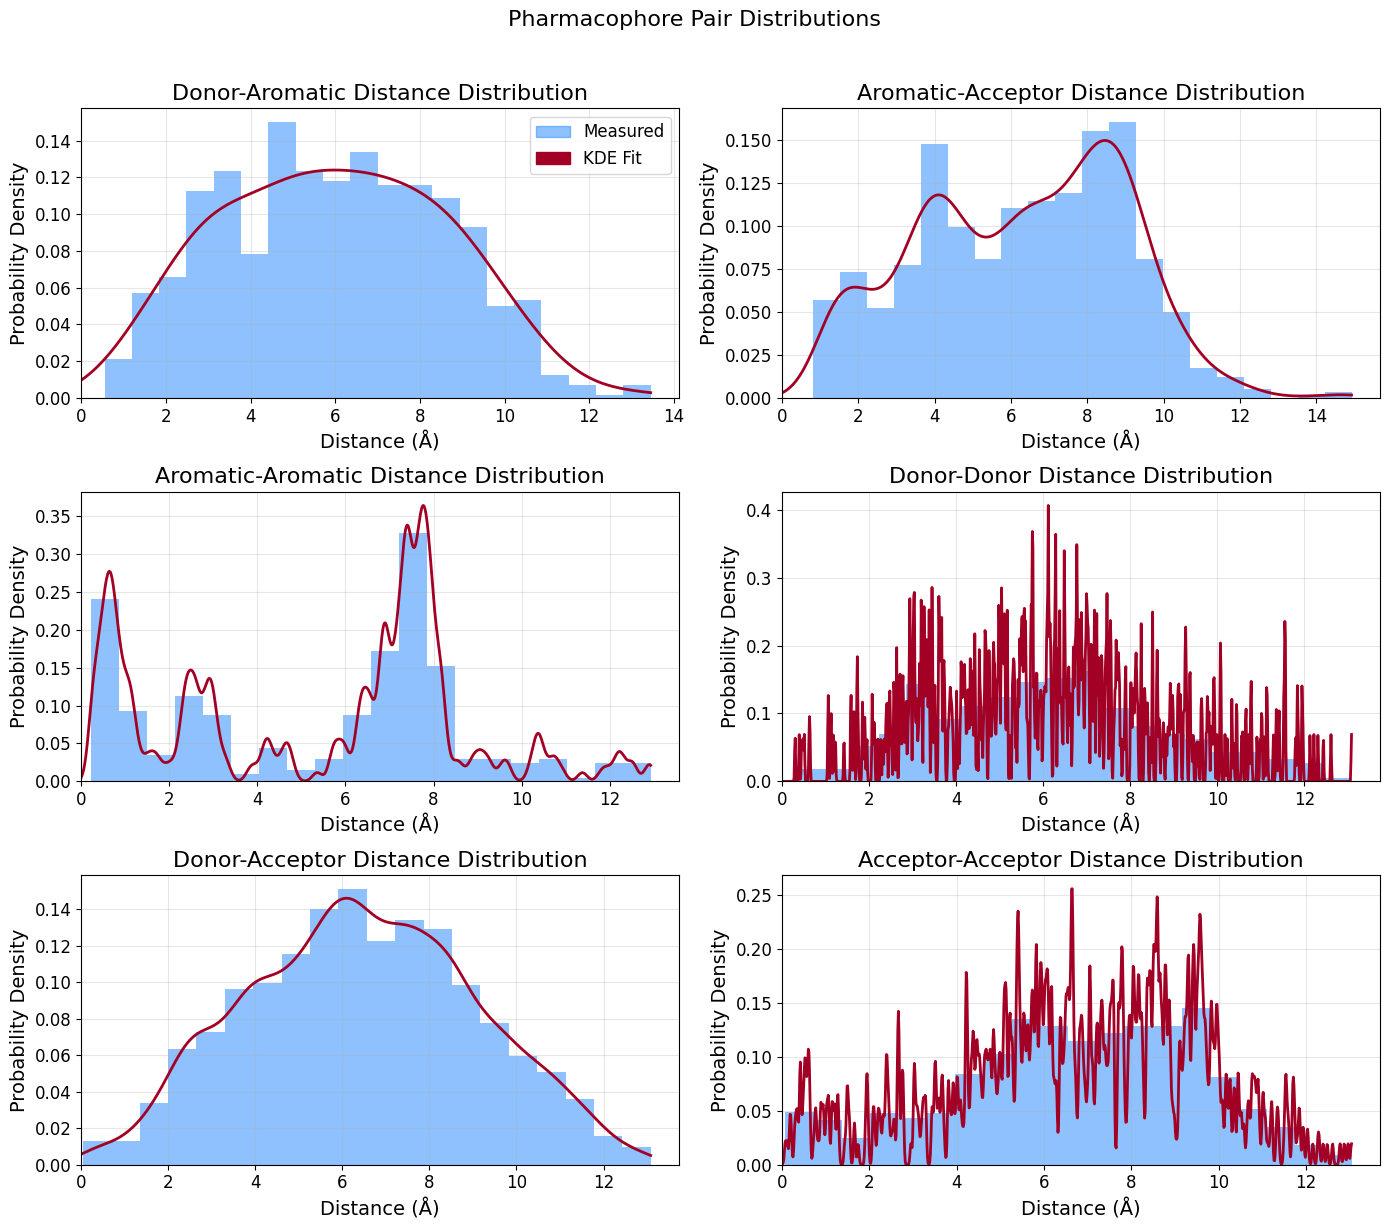

In [68]:
def plot_pharmacophore_distributions(kdes, distances_dict, pairs, n_bins=20):
    """
    Visualize the distributions of pharmacophore pair distances and their KDE fits.
    
    Parameters:
    -----------
    kdes : dict
        Dictionary of fitted KDE models for each pharmacophore pair
    distances_dict : dict
        Dictionary of distance arrays for each pharmacophore pair
    pairs : list
        List of pharmacophore pairs to visualize
    n_bins : int
        Number of histogram bins
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure with the visualization
    """
    # Set up the figure
    n_pairs = len(pairs)
    n_cols = 2
    n_rows = (n_pairs + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    fig.suptitle("Pharmacophore Pair Distributions", fontsize=16, y=1.02)
    
    # Flatten axes if needed
    if n_rows > 1:
        axes = axes.flatten()
    elif n_cols > 1:
        axes = np.array([axes[0], axes[1]])
    else:
        axes = np.array([axes])
    
    # Colors for visualization
    hist_color = '#1E85FC'
    kde_color = '#A20025'
    
    # Plot each distribution
    for i, pair in enumerate(pairs):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        distances = distances_dict[pair]
        kde = kdes[pair]
        
        if len(distances) == 0 or kde is None:
            ax.text(0.5, 0.5, f"No data for {pair}", 
                   ha='center', va='center', transform=ax.transAxes)
            continue
        
        # Plot histogram
        ax.hist(
            distances, 
            bins=n_bins, 
            alpha=0.5, 
            density=True, 
            color=hist_color
        )
        
        # Plot KDE
        x = np.linspace(0, np.max(distances), 1000).reshape(-1, 1)
        log_density = kde.score_samples(x)
        ax.plot(x, np.exp(log_density), color=kde_color, linewidth=2)
        
        # Set labels and title
        ax.set_title(f"{pair} Distance Distribution")
        ax.set_xlabel("Distance (Å)")
        ax.set_ylabel("Probability Density")
        ax.set_xlim(left=0)
        ax.grid(True, alpha=0.3)
    
    # Add legend to the first plot
    if len(axes) > 0:
        from matplotlib.patches import Rectangle
        legend_elements = [
            Rectangle((0, 0), 1, 1, color=hist_color, alpha=0.5, label='Measured'),
            Rectangle((0, 0), 1, 1, color=kde_color, label='KDE Fit')
        ]
        axes[0].legend(handles=legend_elements, loc='upper right')
    
    # Hide unused subplots
    for i in range(n_pairs, len(axes)):
        axes[i].set_visible(False)
    
    fig.tight_layout()
    save_figure(fig, "pharmacophore_distributions")
    
    return fig

# Visualize the distance distributions and KDE fits
dist_fig = plot_pharmacophore_distributions(kde_models, pair_distances, interesting_pairs)

### <b> <font color='#A20025'> Scoring New Molecules with FRESCO

Now we can use our fitted pharmacophore distance models to score new molecules.
A high score indicates that the molecule's pharmacophore arrangement is similar
to what we observed in the fragment library, suggesting it might be a good binder.


In [88]:
def prepare_molecule_for_scoring(smiles):
    """
    Prepare a molecule for scoring by generating 3D coordinates.
    
    Parameters:
    -----------
    smiles : str
        SMILES string of the molecule
        
    Returns:
    --------
    rdkit.Chem.rdchem.Mol
        RDKit molecule with 3D coordinates
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES: {smiles}")
        return None
    
    try:
        # Add hydrogens
        mol = Chem.AddHs(mol)
        
        # Generate 3D coordinates
        AllChem.EmbedMolecule(mol, randomSeed=RANDOM_SEED)
        
        return mol
    
    except Exception as e:
        print(f"Error preparing molecule: {str(e)}")
        return None

# Score example molecules
example_smiles = 'Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1'
print(f"\nScoring example molecule: {example_smiles}")
example_mol = prepare_molecule_for_scoring(example_smiles)


Scoring example molecule: Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1


In [99]:
# Extract pharmacophore features
example_pcore_df = compute_pharmacophore_data(example_mol)
display(example_pcore_df)

pcore                                             smiles  mol_id  \
0     Donor  [H]O[C@]([H])(C(=O)N([H])c1c([H])c([H])c([H])c...       0   
1     Donor  [H]O[C@]([H])(C(=O)N([H])c1c([H])c([H])c([H])c...       0   
2     Donor  [H]O[C@]([H])(C(=O)N([H])c1c([H])c([H])c([H])c...       0   
3  Acceptor  [H]O[C@]([H])(C(=O)N([H])c1c([H])c([H])c([H])c...       0   
4  Acceptor  [H]O[C@]([H])(C(=O)N([H])c1c([H])c([H])c([H])c...       0   
5  Acceptor  [H]O[C@]([H])(C(=O)N([H])c1c([H])c([H])c([H])c...       0   
6  Aromatic  [H]O[C@]([H])(C(=O)N([H])c1c([H])c([H])c([H])c...       0   
7  Aromatic  [H]O[C@]([H])(C(=O)N([H])c1c([H])c([H])c([H])c...       0   
8  Aromatic  [H]O[C@]([H])(C(=O)N([H])c1c([H])c([H])c([H])c...       0   

    coord_x   coord_y   coord_z  
0 -1.253786 -0.513875  0.553786  
1  1.359554  0.599488 -0.053459  
2  3.233774  0.743821  2.078542  
3  3.151723  0.940963 -1.458001  
4  3.233774  0.743821  2.078542  
5  7.154461  0.409603 -0.561485  
6 -4.835941  0.385581  1.424431  
7 -0.619407  0.323247 -2.045650  
8  6.253320 -0.258946  0.180928

In [90]:
def calculate_pairwise_distances_within_molecule(df_pcores, pcore_a, pcore_b, smile):
    """
    Calculate pairwise distances between two types of pharmacophore features
    within a single molecule.
    
    Parameters:
    -----------
    df_pcores : pandas.DataFrame
        DataFrame containing pharmacophore data
    pcore_a : str
        First pharmacophore type
    pcore_b : str
        Second pharmacophore type
    smile : str
        SMILES string of the molecule
        
    Returns:
    --------
    numpy.ndarray
        Array of pairwise distances
    """
    # Filter for the specified molecule and pharmacophore types
    df_mol = df_pcores[df_pcores['smiles'] == smile]
    df_pcore_a = df_mol[df_mol['pcore'] == pcore_a]
    df_pcore_b = df_mol[df_mol['pcore'] == pcore_b]
    
    if df_pcore_a.empty or df_pcore_b.empty:
        return np.array([])
    
    # Extract coordinates
    coords_a = df_pcore_a[['coord_x', 'coord_y', 'coord_z']].values
    coords_b = df_pcore_b[['coord_x', 'coord_y', 'coord_z']].values
    
    # Calculate distances
    dist_matrix = cdist(coords_a, coords_b, metric='euclidean')
    return dist_matrix.flatten()

# Calculate distances
example_distances = {}
for pair in interesting_pairs:
    pcore_a, pcore_b = pair.split('-')
    distances = calculate_pairwise_distances_within_molecule(
        example_pcore_df, pcore_a, pcore_b, MolToSmiles(example_mol)
    )
    example_distances[pair] = distances
    print(f"{pair}: {len(distances)} distances")

Donor-Aromatic: 9 distances
Aromatic-Acceptor: 9 distances
Aromatic-Aromatic: 9 distances
Donor-Donor: 9 distances
Donor-Acceptor: 9 distances
Acceptor-Acceptor: 9 distances


In [91]:
def score_molecule_with_kdes(kdes, distances_dict, pairs):
    """
    Score a molecule based on how well its pharmacophore distances match
    the reference distributions.
    
    Parameters:
    -----------
    kdes : dict
        Dictionary of fitted KDE models for each pharmacophore pair
    distances_dict : dict
        Dictionary of distance arrays for the molecule
    pairs : list
        List of pharmacophore pairs to consider
        
    Returns:
    --------
    float
        Overall score for the molecule
    """
    scores = []
    
    for pair in pairs:
        kde = kdes.get(pair)
        distances = distances_dict.get(pair, np.array([]))
        
        if kde is not None and len(distances) > 0:
            # Reshape distances for sklearn
            distances = distances.reshape(-1, 1)
            
            # Calculate log density scores
            log_densities = kde.score_samples(distances)
            
            # Convert to probabilities and take the maximum
            probabilities = np.exp(log_densities)
            max_probability = np.max(probabilities)
            
            scores.append(max_probability)
    
    # Calculate overall score (geometric mean to avoid being dominated by a single high score)
    if scores:
        return np.mean(np.log(scores))
        #overall_score = np.exp(np.mean(np.log(scores)))
        #return overall_score
    else:
        return 0.0

# Score the molecule
example_score = score_molecule_with_kdes(kde_models, example_distances, interesting_pairs)
print(f"Score: {example_score:.4f}")


Score: -1.9684


In [100]:
def score_new_molecule(smiles, kde_models, interesting_pairs):
    """
    Score a new molecule using the FRESCO approach.
    
    Parameters:
    -----------
    smiles : str
        SMILES string of the molecule
    kde_models : dict
        Dictionary of fitted KDE models for each pharmacophore pair
    interesting_pairs : list
        List of pharmacophore pairs to consider
        
    Returns:
    --------
    float
        Overall score for the molecule
    """
    # Prepare the molecule
    mol = prepare_molecule_for_scoring(smiles)
    if mol is None:
        return 0.0
    
    # Extract pharmacophore features
    mol_pcore_df = compute_pharmacophore_data(mol)
    
    if mol_pcore_df.empty:
        print("No pharmacophore features found")
        return 0.0
    
    # Calculate pharmacophore distances within the molecule
    mol_distances = {}
    for pair in interesting_pairs:
        pcore_a, pcore_b = pair.split('-')
        distances = calculate_pairwise_distances_within_molecule(
            mol_pcore_df, pcore_a, pcore_b, MolToSmiles(mol)
        )
        mol_distances[pair] = distances
    
    # Score the molecule
    score = score_molecule_with_kdes(kde_models, mol_distances, interesting_pairs)
    
    return score

def score_library_molecules(library_mols, kde_models, interesting_pairs, n_to_score=10):
    """
    Score a set of molecules using the FRESCO approach.
    
    Parameters:
    -----------
    library_mols : list
        List of RDKit molecule objects
    kde_models : dict
        Dictionary of fitted KDE models for each pharmacophore pair
    interesting_pairs : list
        List of pharmacophore pairs to consider
    n_to_score : int
        Number of molecules to score
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with molecules and their scores
    """
    results = []
    visited = set([])
    
    # Score a subset of molecules
    for i, mol in enumerate(library_mols[:n_to_score]):
        if mol is None:
            continue
            
        # Convert to SMILES
        smiles = Chem.MolToSmiles(mol)
        if smiles in visited:
            continue
        visited.add(smiles)
        
        # Score the molecule
        score = score_new_molecule(smiles, kde_models, interesting_pairs)
        
        results.append({
            'Index': i,
            'SMILES': smiles,
            'Score': score
        })
    
    # Create DataFrame and sort by score
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Score', ascending=False)
    
    return results_df

scored_molecules = score_library_molecules(
    butina_sampled_molecules, 
    kde_models, 
    interesting_pairs,
    n_to_score=100
)

print("\nTop scoring molecules:")
print(scored_molecules.head(10))

[18:07:14] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:14] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:14] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:14] UFFTYPER: Unrecognized atom type: *_ (24)
[18:07:15] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:15] UFFTYPER: Unrecognized atom type: *_ (12)
[18:07:15] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:15] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:15] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:15] UFFTYPER: Unrecognized atom type: *_ (24)
[18:07:16] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:16] UFFTYPER: Unrecognized atom type: *_ (24)
[18:07:16] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:16] UFFTYPER: Unrecognized atom type: *_ (15)
[18:07:16] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:16] UFFTYPER: Unrecognized atom type: *_ (15)
[18:07:16] UFFTYPER: Unrecognized atom type: *_ (0)
[18:07:16] UFFTYPER: Unrecognized atom type: *_ (29)
[18:07:16] UFFTYPER: Unrecognized atom type: *_ (0)
[18:0


Top scoring molecules:
    Index                                             SMILES     Score
18     33  [1*]N1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc([2*])cc... -1.587429
11     21  [1*]C1(CS(=O)(=O)N2Cc3ccc([2*])cc3C3(CCN(c4cnc... -1.619608
17     30  [1*]c1ccc(N(C(=O)c2c[nH]c(=O)[nH]2)C(C(=O)NCCc... -1.752006
46     74  CCC(C)[C@H]1CC[C@@]2(C)[C@@H]3C=C[C@]45OC(O)[C... -1.769451
36     60  [1*]C1(C(=O)Nc2cncc3ccccc23)CNS(=O)(=O)c2ccc([... -1.772910
39     64  [1*]c1ccc2c(c1)[C@H](C(=O)Nc1cncc3ccccc13)CN([... -1.808510
52     82       CCC(C)[C@]1(C#N)O[C@H](NC=O)[C@@H](O)[C@H]1O -1.816100
51     81  N#C[C@@]1(C2CCC3OCCC3C2)O[C@H](NC=O)[C@@H](O)[... -1.820443
48     76  N#C[C@@]1(c2cc(=O)[nH]c3ccccc23)O[C@H](NC=O)[C... -1.845439
14     26  Cc1ccc2c([C@]3(C#N)O[C@H](NC=O)[C@@H](O)[C@H]3... -1.850355


**Code for Figure 7.13.** 3D pharmacophoric features (H-bond donors in red, H-bond acceptors in blue, aromatics in green) for one possible conformer sampled from an arbitrary molecule.

In [82]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit.Chem import Draw
import py3Dmol

smiles = 'C1=CC2=C(C=C1)C=NC=C2NC(=O)[C@H]3C4=C(OCC3)C=CC(=C4)Cl'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol, AllChem.ETKDG())

# Compute 3D coordinates
AllChem.UFFOptimizeMolecule(mol)

# Get the pharmacophoric features
hbd_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 8 and atom.GetTotalNumHs() > 0]  # Hydrogen bond donors
hba_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 7 or (atom.GetAtomicNum() == 8 and atom.GetTotalNumHs() == 0)]  # Hydrogen bond acceptors
aromatic_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetIsAromatic()]  # Aromatic atoms

atom_colors = {}
for idx in hbd_atoms:
    atom_colors[idx] = (1, 0, 0)  # Red for HBD
for idx in hba_atoms:
    atom_colors[idx] = (0, 0, 1)  # Blue for HBA
for idx in aromatic_atoms:
    atom_colors[idx] = (0, 1, 0)  # Green for Aromatics

# Generate 3D coordinates for visualization
def mol_to_3Dview(mol, atom_colors=None):
    mol_block = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=800, height=600)
    viewer.addModel(mol_block, 'mol')
    viewer.setStyle({'stick': {}})
    if atom_colors:
        for atom_idx, color in atom_colors.items():
            viewer.setStyle({'model': -1, 'serial': atom_idx + 1}, {'stick': {'colorscheme': {'prop': 'elem', 'map': [[0, 'black'], [1, 'red'], [2, 'blue'], [3, 'green']], 'radius': 0.5}}})
            viewer.addSphere({'center': {'x': mol.GetConformer().GetAtomPosition(atom_idx).x,
                                         'y': mol.GetConformer().GetAtomPosition(atom_idx).y,
                                         'z': mol.GetConformer().GetAtomPosition(atom_idx).z},
                              'radius': 0.5, 'color': f'rgb({color[0]*255},{color[1]*255},{color[2]*255})', 'opacity': 0.6})
    viewer.zoomTo()
    return viewer

viewer = mol_to_3Dview(mol, atom_colors)
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## <b> <font color='#A20025'> Summary

In this chapter, we explored unsupervised learning techniques for drug discovery:
 
1. **Dimensionality Reduction**: We used Self-Organizing Maps (SOMs) and UMAP to visualize high-dimensional 
   chemical data and identify potential drug repurposing candidates.
 
2. **Clustering**: We applied hierarchical and Taylor-Butina clustering to design diverse compound libraries,
   comparing their effectiveness in selecting representative molecules.
 
3. **Density Estimation**: We implemented a simplified version of the FRESCO approach, using kernel density 
   estimation to model pharmacophore distance distributions and score new molecules.
 
These methods provide powerful tools for exploring chemical space, designing compound libraries, and 
identifying promising drug candidates without requiring labeled training data.

## <b> <font color='#A20025'> References

[1] Boby, M., Fearon, D., Ferla, M., et al. (2023). Open Science Discovery of Potent Non-Covalent SARS-CoV-2 Main Protease Inhibitors. doi: https://doi.org/10.1101/2020.10.29.339317

[2] Owen, D. R. et al. An oral SARS-CoV-2 M¡sup¿pro¡/sup¿ inhibitor clinical candidate for the treatment of COVID-19. Science 2021, 374, 1586–1593. (12) 

[3] Unoh, Y.; Uehara, S.; Nakahara, K.; Nobori, H.; Yamatsu, Y.; Yamamoto, S.; Maruyama, Y.; Taoda, Y.; Kasamatsu, K.; Suto, T., et al. Discovery of S-217622, a Noncovalent Oral SARS-CoV-2 3CL Protease Inhibitor Clinical Candidate for Treating COVID-19. Journal of Medicinal Chemistry 2022, 65, 6499–6512.

[4] Hamel, Lutz & Brown, Chris. (2012). Improved Interpretability of the Unified Distance Matrix with Connected Components. 7th International Conference on Data Mining (DMIN'11).

[5] Corsello, S. M.; Bittker, J. A.; Liu, Z.; Gould, J.; McCarren, P.; Hirschman, J. E.; Johnston, S. E.; Vrcic, A.; Wong, B.; Khan, M.; Asiedu, J.; Narayan, R.; Mader, C. C.; Subramanian, A.; Golub, T. R. The Drug Repurposing Hub: A Next-Generation Drug Library and Information Resource. Nat. Med. 2017, 23, 405−408

[6] Prada Gori, D. N. et al. (2023). Drug repurposing screening validated by experimental assays identifies two clinical drugs targeting SARS-CoV-2 main protease. Front. Drug Discov. https://doi.org/10.3389/fddsv.2022.1082065

[7] Starmer, J. UMAP: Mathematical Details (clearly explained!!!). StatQuest. https://www.youtube.com/watch?v=jth4kEvJ3P8

[8] Coenen, A., Pearce, A. Understanding UMAP. https://pair-code.github.io/understanding-umap/

[9] Bemis, G. W. & Murcko, M. A. The Properties of Known Drugs. 1. Molecular Frameworks J. Med. Chem. 1996 39 (15), 2887-2893. DOI: 10.1021/jm9602928

[10] Hu, Y.; Stumpfe, D.; Bajorath, J. (2011). Lessons Learned from Molecular Scaffold Analysis. J. Chem. Inf. Model. DOI: 10.1021/ci200179y

[11] SMIRKS - A Reaction Transform Language. Daylight. https://www.daylight.com/dayhtml/doc/theory/theory.smirks.html

[12] Taylor, R. (1995). Simulation Analysis of Experimental Design Strategies for Screening Random Compounds as Potential New Drugs and Agrochemicals. https://doi.org/10.1021/ci00023a009

[13] Butina, D. (1999). Unsupervised Data Base Clustering Based on Daylight's Fingerprint and Tanimoto Similarity: A Fast and Automated Way To Cluster Small and Large Data Sets. https://doi.org/10.1021/ci9803381

[14] https://www.rdkit.org/docs/RDKit_Book.html#additional-information-about-the-fingerprints

[15] Wild, D. J. & Blankley, C. J. (2000). Comparison of 2D Fingerprint Types and Hierarchy Level Selection Methods for Structural Grouping Using Ward’s Clustering. J. Chem. Inf. Comput. Sci.

[16] Brown, R. D.; Martin, Y. C. Use of Structure-Activity Data To Compare Structure-Based Clustering Methods and Descriptors for Use in Compound Selection. J. Chem. Inf. Comput. Sci. 1996, 36, 572- 584.

[17] O’Boyle, N.M., Sayle, R.A. Comparing structural fingerprints using a literature-based similarity benchmark. J Cheminform 8, 36 (2016). https://doi.org/10.1186/s13321-016-0148-0

[18] de Souza Neto, L. R., Moreira-Filho, J. T., Neves, B. J., Maidana, R. L. B. R., Guimarães, A. C. R., Furnham, N., Andrade, C. H., & Silva, F. P., Jr (2020). In silico Strategies to Support Fragment-to-Lead Optimization in Drug Discovery. Frontiers in chemistry, 8, 93. https://doi.org/10.3389/fchem.2020.00093

[19] Seidel, T., Ibis, G., Bendix, F., Wolber, G. (2010). Strategies for 3D pharmacophore-based virtual screening. Drug Discovery Today: Technologies. https://doi.org/10.1016/j.ddtec.2010.11.004

[20] McCorkindale, W., et al. (2022). Fragment-Based Hit Discovery via Unsupervised Learning of Fragment-Protein Complexes. bioRxiv 2022.11.21.517375; doi: https://doi.org/10.1101/2022.11.21.517375

[21] https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html

[22] https://pberba.github.io/stats/2020/01/17/hdbscan/

[23] https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html